In [2]:
import ee
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import plotnine
from plotnine import *

import sys
import itertools
from tqdm.auto import tqdm

from dfply import *

In [3]:
# authenticate earthengine api
ee.Initialize()

In [4]:
# append sys_path, and import custom moduls
sys.path.append('./')
sys.path.append('../Step_1_UNET_predict_future_urbanization/torch_modules')

from Modules.Modules import filter_exclude, get_img_df
from Modules.Parallize_df import parallelize_dataframe
from Global_Variables import proj_yr_selected

# might need reload modules as the code progrocessing
%load_ext autoreload
%autoreload 2

In [5]:
# the NCP image mask
NCP_img_mask = ee.ImageCollection("users/wangjinzhulala/North_China_Plain_Python/classification_img/Control_1990_1992").first().mask()
NCP_shp = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_province_boundry")

NCP_urban_maps = ee.Image("users/wangjinzhulala/China_built_up/06_temporal_corrected_classification/Mosaic_only_forward_China_huadong_sample_ensemble")
year_val_code = list(zip(range(1992,2020,3),range(10,0,-1)))

# import the 30m landcover of 2010
LUCC_NCP = {yr:ee.Image(f"users/wangjinzhulala/Paper_3/01_LUCC_1990_2019_china/CLCD_v01_{yr}").mask(NCP_img_mask) for yr in range(1990,2020)}
lucc_code = dict(zip([f"{i}" for i in range(1,10)],['Cropland','Forest','Shrub','Grassland','Water','Sonw','Barren','Impervious','Wetland']))

# get the pixel size for exporting img later
one_GAEZ_img = ee.Image("users/wangjinzhulala/Paper_3/03_GAEZ/GAEZ_2_Moisture_Annual_P_PET_1981_2010_Historical")
GAEZ_pix_scale = one_GAEZ_img.projection().nominalScale().getInfo()

# the GAEZ_urban_encroach area
SSP_future_urban_map_stats_hist = pd.read_csv('./result_csv/SSP_future_urban_map_stats_hist.csv')

# read yearbook cropland area
yearbook_area = pd.read_csv('./result_csv/yearbook_area.csv')

# read the corrected GAEZ_2010_cropland
GAEZ_cropland_2020_corrected = pd.read_pickle('./result_csv/GAEZ_cropland_2020_corrected.pkl')

# read the GAEZ_cropland_area_project
GAEZ_cropland_area_project = pd.read_pickle('./result_csv/urban_encroach_img.pkl')

### 1) Explore the reclmation_area and cropland_increate_area

In [6]:
# pair Chinese city names with english spelling
city_cn_en = dict(zip(['北京市','天津市', '河北省','江苏省', '安徽省', '河南省', '山东省'],
             ['Beijing','Tianjin', 'Hebei','Jiangsu', 'Anhui', 'Henan', 'Shandong']))

In [7]:
# the reclamation data from Brett Nature paper
land_reclimate_invest = pd.read_csv('../../Data/06_Yearbook/GDP_Population/land_reclimation_invest_ml_yuan.csv')
land_reclimate_invest = land_reclimate_invest.set_index('Province').stack().reset_index()
land_reclimate_invest.columns = ['Province','year','invest_1e6_CNY']
land_reclimate_invest['year'] = land_reclimate_invest['year'].astype(int)

land_reclimate_area = pd.read_csv('../../Data/06_Yearbook/GDP_Population/land_reclimation_area_k_ha.csv')
land_reclimate_area = land_reclimate_area.set_index('Province').stack().reset_index()
land_reclimate_area.columns = ['Province','year','area_k_ha']
land_reclimate_area['year'] = land_reclimate_area['year'].astype(int)


# the cropland increase from yearbook
yearbook_reclamation = pd.read_csv('../../Data/06_Yearbook/GDP_Population/yearbook_land_reclimation_total_area_ha.csv')
yearbook_reclamation = yearbook_reclamation.set_index('Province').stack().reset_index().replace(city_cn_en)
yearbook_reclamation.columns = ['Province','year','yearbook_reclamation_ha']
yearbook_reclamation['yearbook_reclamation_kha'] = yearbook_reclamation['yearbook_reclamation_ha'] / 1000
yearbook_reclamation['year'] = yearbook_reclamation['year'].astype(int)

yearbook_cropland_increase = pd.read_csv('../../Data/06_Yearbook/GDP_Population/yearbook_land_reclimation_cropland_increase_ha.csv')
yearbook_cropland_increase = yearbook_cropland_increase.set_index('Province').stack().reset_index().replace(city_cn_en)
yearbook_cropland_increase.columns = ['Province','year','yearbook_cropland_increase_ha']
yearbook_cropland_increase['yearbook_cropland_increase_kha'] = yearbook_cropland_increase['yearbook_cropland_increase_ha'] / 1000
yearbook_cropland_increase['year'] = yearbook_cropland_increase['year'].astype(int)

# merge all land reclamation data
land_reclimation_record = land_reclimate_invest.merge(land_reclimate_area).merge(yearbook_reclamation)\
              .merge(yearbook_cropland_increase) >> mask(X.Province.isin(city_cn_en.values()))
              
              
# get the compensated GAEZ area
cropland_area_compensated = pd.read_csv('./result_csv/cropland_area_compensated.csv')

# get the cropland area after encroachment
cropland_area_after_encroachment = pd.read_csv('./result_csv/cropland_area_after_encroachment.csv')

#### 1-1) The reclimation data from Brett Nature paper is the same with the yearbook reclamation records
- there are some outliers, but overall, these two datasets are the same 

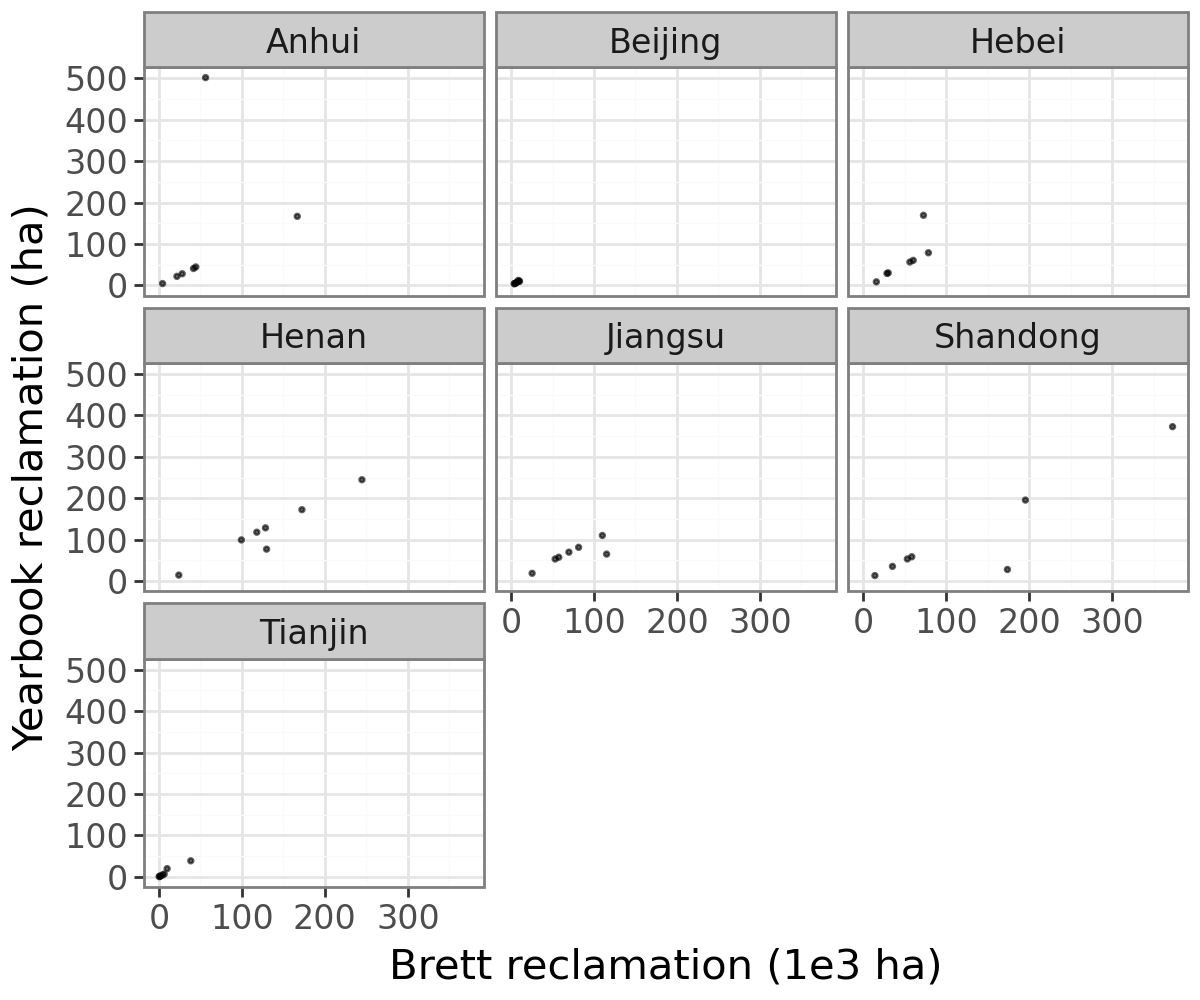

In [8]:
# plot the area change
plotnine.options.figure_size = (6,5)
plotnine.options.dpi = 100

(ggplot(land_reclimation_record)
+ geom_point(aes(x='area_k_ha',y='yearbook_reclamation_kha'),size=0.5,alpha=0.6)
+ facet_wrap('Province',ncol=3)
+ theme_bw(base_size=15)
+ xlab('Brett reclamation (1e3 ha)')
+ ylab('Yearbook reclamation (ha)')
 )

#### 2-2) Rclamation | Cropland_increase, Compare their value in 2020

In [9]:
# get the reclamation/urban_increase area
increase_area = land_reclimation_record.copy()
increase_area = increase_area.sort_values(['Province','year']).reset_index(drop=True)
increase_area['cumsum_reclamation_kha'] = increase_area.groupby('Province',group_keys=False).apply(lambda df:df.cumsum(),include_groups=False)['yearbook_reclamation_kha']
increase_area['cumsum_cropland_increase_kha'] = increase_area.groupby('Province',group_keys=False).apply(lambda df:df.cumsum(),include_groups=False)['yearbook_cropland_increase_kha']
increase_area = increase_area >> select(['Province','year','cumsum_reclamation_kha','cumsum_cropland_increase_kha'])

increase_area_sum = increase_area.groupby(['year']).sum(numeric_only=True).reset_index()
increase_area_sum

,year,cumsum_reclamation_kha,cumsum_cropland_increase_kha
0,2009,352.61702,109.58483
1,2010,848.47680,223.62019
2,2011,1179.41500,312.97182
3,2012,1879.93897,399.88984
4,2013,2452.80133,501.62037
5,2014,2558.56277,529.48771
6,2015,3431.15098,567.74757


c:\Users\Jinzhu\miniconda3\envs\gee\Lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


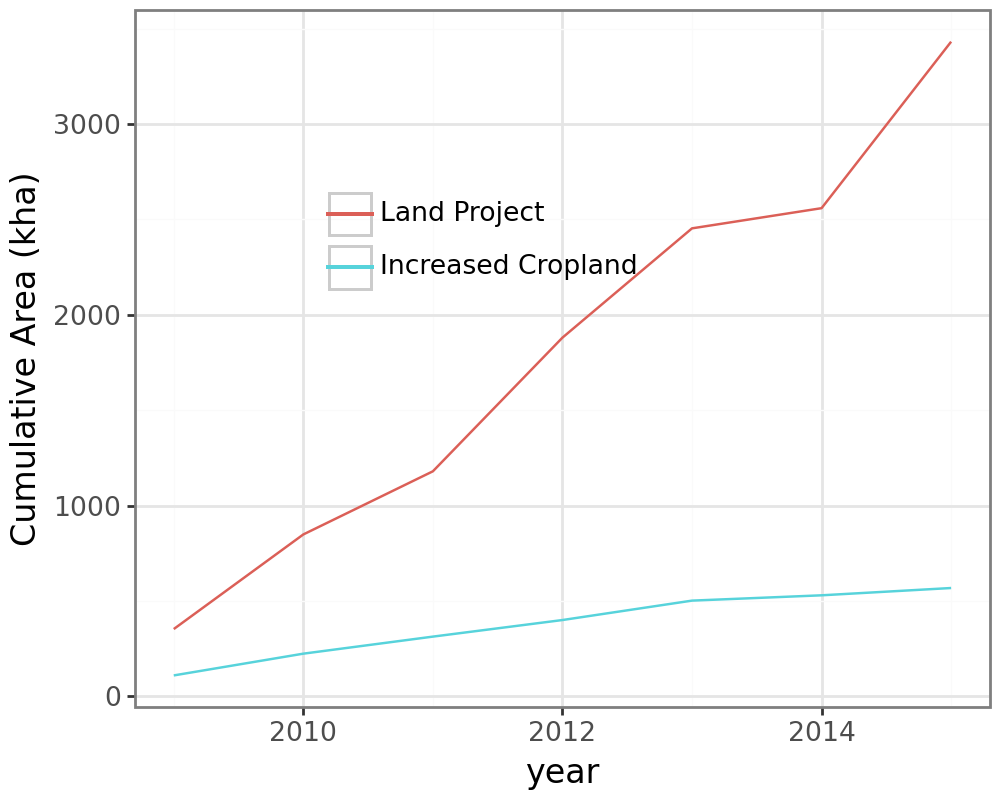

In [10]:
# plot the area change
plotnine.options.figure_size = (5,4)
plotnine.options.dip = 100

# plot the trend
(ggplot()
 + geom_line(increase_area_sum,aes(x='year',y='cumsum_reclamation_kha',color=['Land Project']*len(increase_area_sum)))
 + geom_line(increase_area_sum,aes(x='year',y='cumsum_cropland_increase_kha',color=['Increased Cropland']*len(increase_area_sum)))
 + theme_bw(base_size=12)
 + ylab('Cumulative Area (kha)')
 + theme(legend_title=element_blank(),legend_position=(0.35,0.7),legend_background=element_blank())
)

#### 2-3) The cumsum_cropland_increase_kha should be used as the cropland increment.
- comparing the increase_area_sum with GAEZ_urban_encroach_sum
- we can see that the cumsum_cropland_increase_kha is much closer to GAEZ_actual_encroachment_kha
- so, cumsum_cropland_increase_kha will be used as the cropland increments

In [11]:
urban_encroachment_area_2020 = pd.read_csv('./result_csv/urban_encroachment_area_df.csv').query('year == 2020').groupby(['Province']).mean(numeric_only=True).reset_index()
urban_encroachment_area_2020

,Province,year,encroach_area_kha_mean,encroach_area_kha_top,encroach_area_kha_bot
0,Anhui,2020.0,0.0,82.739360,0.0
1,Beijing,2020.0,0.0,75.217752,0.0
2,Hebei,2020.0,0.0,60.551564,0.0
3,Henan,2020.0,0.0,70.917978,0.0
4,Jiangsu,2020.0,0.0,104.503433,0.0
5,Shandong,2020.0,0.0,74.214983,0.0
6,Tianjin,2020.0,0.0,47.373474,0.0


### 2 regression cropland_increase with year
- Here multiply the area by two because the NCP is a double cropping system

In [12]:
# get the cumcum cropland increase
cropland_increase_yearbook_NCP = yearbook_cropland_increase >> mask(X.Province.isin(city_cn_en.values()))
cropland_increase_yearbook_NCP = cropland_increase_yearbook_NCP.sort_values(['Province','year']).reset_index(drop=True)
cropland_increase_yearbook_NCP['yearbook_cropland_increase_kha'] = cropland_increase_yearbook_NCP['yearbook_cropland_increase_kha'] * 2
cropland_increase_yearbook_NCP['yearbook_cumsum_increase_kha'] = cropland_increase_yearbook_NCP.groupby('Province')\
                                  .cumsum().reset_index()['yearbook_cropland_increase_kha']

c:\Users\Jinzhu\miniconda3\envs\gee\Lib\site-packages\plotnine\themes\themeable.py:2398: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


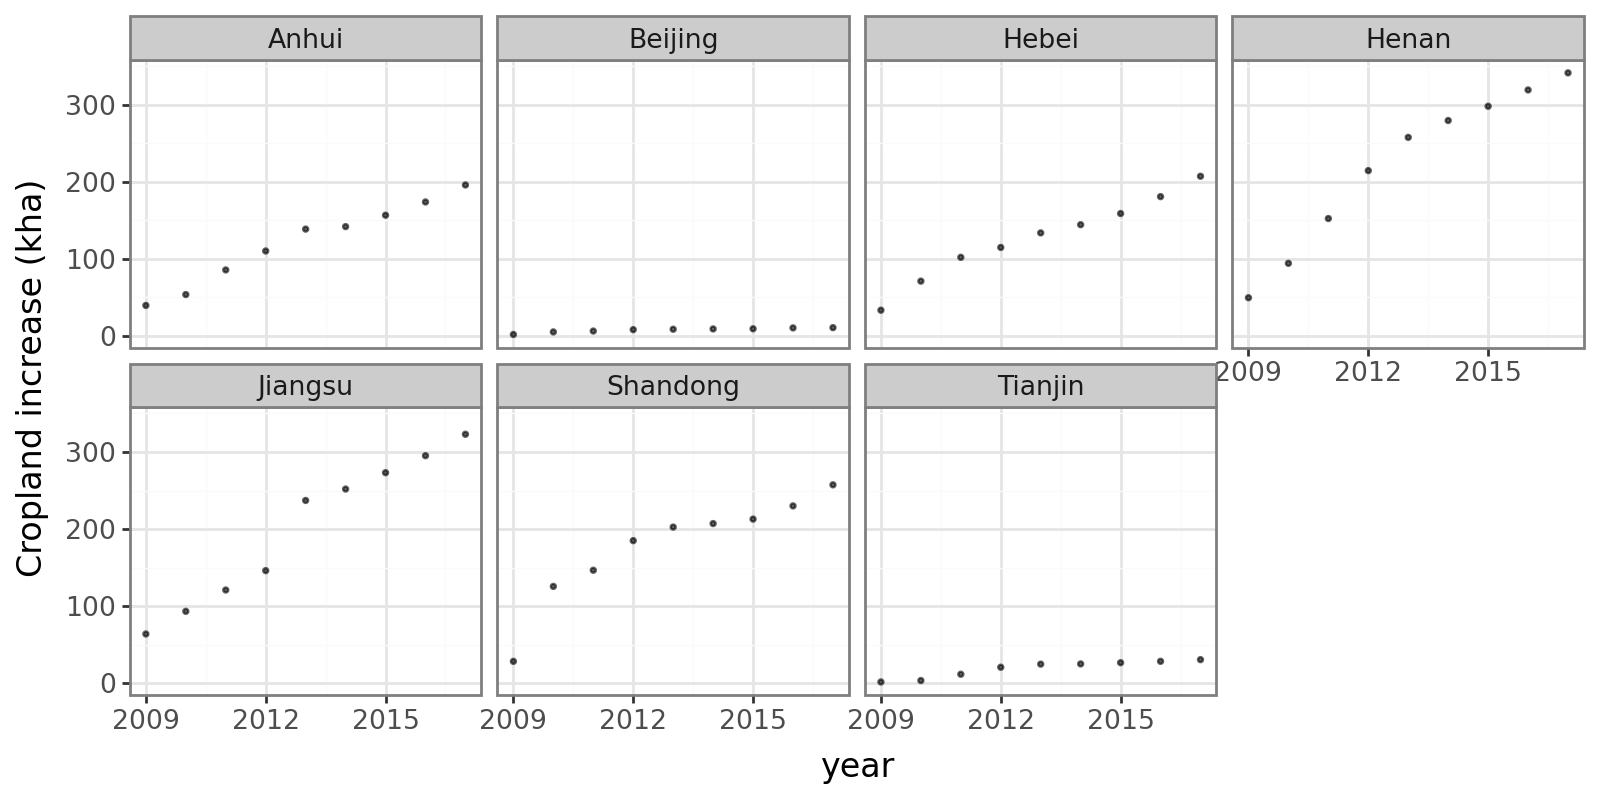

In [13]:
# plot the area change
plotnine.options.figure_size = (8,4)
plotnine.options.dip = 100

(ggplot(cropland_increase_yearbook_NCP)
+ geom_point(aes(x='year',y='yearbook_cumsum_increase_kha'),size=0.5,alpha=0.6)
+ scale_x_continuous(breaks=range(2000,2020,3))
+ facet_wrap('Province',ncol=4)
+ theme_bw(base_size=12)
+ theme(subplots_adjust={'wspace': 0.2})
+ ylab('Cropland increase (kha)')
 )

In [14]:
# get the predictions

pred_dfs = []
for idx,df in cropland_increase_yearbook_NCP.groupby('Province'):

  # get data
  x = df['year']
  y = df['yearbook_cumsum_increase_kha']
  x = sm.add_constant(x)

  # construct the model
  mod = sm.OLS(y, x).fit()

  # make predictions
  pred_df = pd.DataFrame({'year':range(2009,2101)})
  pred_df = sm.add_constant(pred_df)

  rst_invertal = mod.get_prediction(pred_df).summary_frame(alpha=0.05)
  rst_invertal['Province'] = idx
  rst_invertal['year'] = pred_df['year']

  pred_dfs.append(rst_invertal)

# get the pred_df
future_cropland_increase = pd.concat(pred_dfs)

In [96]:
# Get the abosolute crop land area increase for 2020
cropland_increase_2020 = future_cropland_increase.query('year == 2020')
# Get the cumulative cropland increase since 2020
cropland_increase_since_2020 = future_cropland_increase.query('year >= 2020')

# Subtract the 2020 cropland increase from the cumulative cropland increase since 2020, 
# so that to get the cumulatative cropland increase since 2020
cropland_increase_since_2020 = cropland_increase_since_2020.merge(cropland_increase_2020,on='Province')
cropland_increase_since_2020['mean'] = cropland_increase_since_2020.eval('mean_x - mean_y')
cropland_increase_since_2020['obs_ci_lower'] = cropland_increase_since_2020.eval('obs_ci_lower_x - mean_y')
cropland_increase_since_2020['obs_ci_upper'] = cropland_increase_since_2020.eval('obs_ci_upper_x - mean_y')
cropland_increase_since_2020['obs_ci_lower'] = cropland_increase_since_2020['obs_ci_lower'].apply(lambda x:0 if x<0 else x)

cropland_increase_since_2020['year'] = cropland_increase_since_2020['year_x']

cropland_increase_since_2020[['area_kha',"area_kha_bot",'area_kha_top']] = cropland_increase_since_2020[['mean','obs_ci_lower','obs_ci_upper']]
cropland_increase_since_2020['area_kha_std'] = cropland_increase_since_2020.eval('area_kha_top - area_kha')
cropland_increase_since_2020[['mean','obs_ci_lower','obs_ci_upper']] = cropland_increase_since_2020[['mean','obs_ci_lower','obs_ci_upper']] / 100


cropland_increase_since_2020 = cropland_increase_since_2020[['Province','year','mean','obs_ci_lower','obs_ci_upper','area_kha',"area_kha_bot",'area_kha_top','area_kha_bot']]

cropland_increase_since_2020.to_csv('./result_csv/cropland_increase_since_2020.csv',index=False)

c:\Users\Jinzhu\miniconda3\envs\gee\Lib\site-packages\plotnine\themes\themeable.py:2398: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


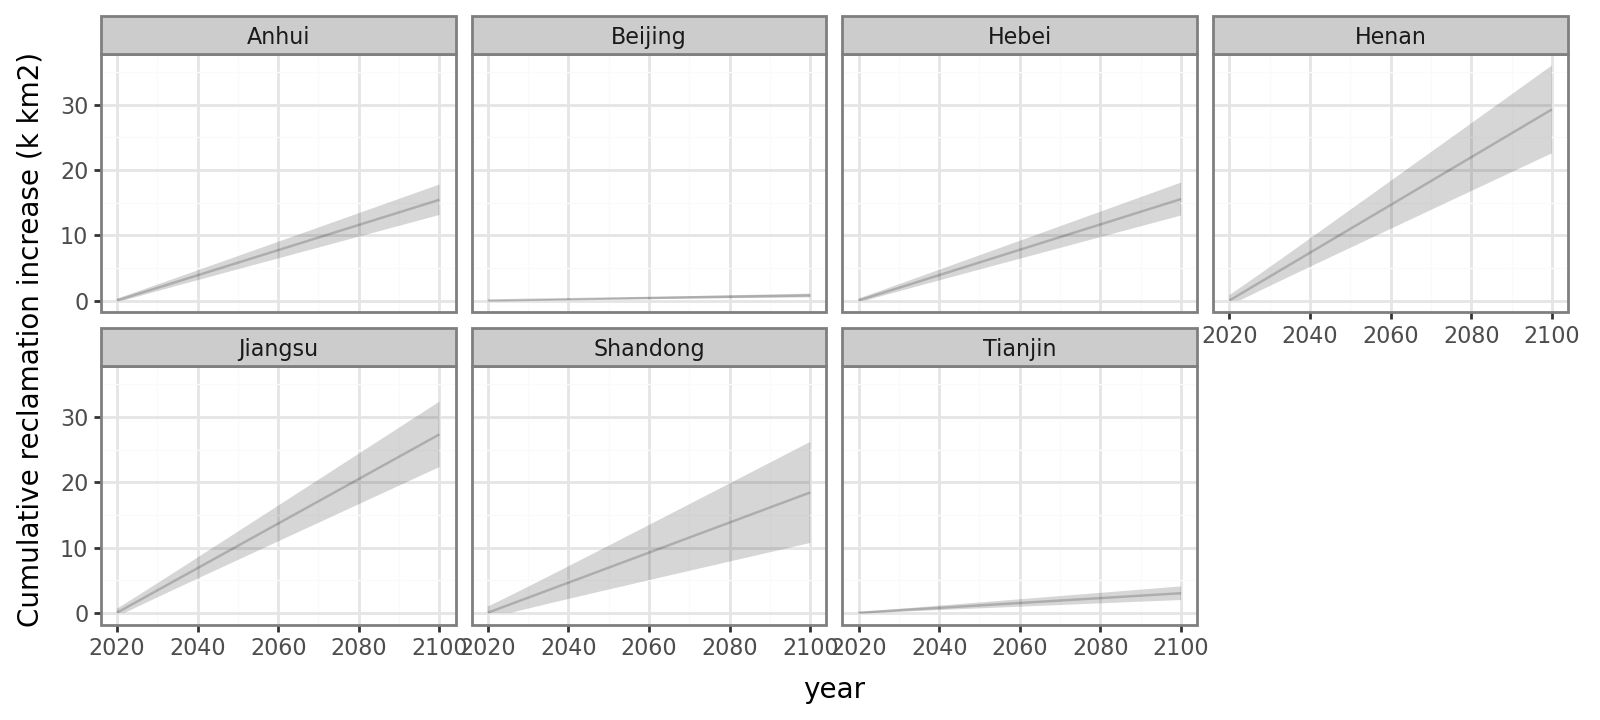

In [97]:
# plot the area change
plotnine.options.figure_size = (8,3.6)
plotnine.options.dip = 100

g = (ggplot()
# + geom_point(cropland_increase_yearbook_NCP,aes(x='year',y='yearbook_cumsum_increase_kha'),size=0.5,alpha=0.6)
+ geom_line(cropland_increase_since_2020,aes(x='year',y='mean'),size=0.5,alpha=0.2)
+ geom_ribbon(cropland_increase_since_2020,aes(x='year',ymin='obs_ci_lower',ymax='obs_ci_upper'),size=0.5,alpha=0.2)
+ facet_wrap('Province',ncol=4)
+ theme_bw(base_size=10)
+ theme(subplots_adjust={'wspace': 0.15})
+ ylab('Cumulative reclamation increase (k km2)')
# + coord_cartesian(xlim = (2009,2100), ylim = (0,1000))
 )

g

In [17]:
# g.save('/content/sup_8_2_year_fit_reclamation.svg')

#### 2-3) Compare the reclamation_area with urban_encroachment_area

In [84]:
# read urban_encroach_cropland area df
urban_encroachment_area_df = pd.read_csv('./result_csv/urban_encroachment_area_df.csv') >> mask(X.Scenario != 'SSP4')
urban_encroachment_area_df['year'] = urban_encroachment_area_df['year'].astype(int)

# change area from kha to 1000km2
urban_encroachment_area_df[['encroach_area_1000km2_mean','encroach_area_1000km2_top','encroach_area_1000km2_bot']] = \
  urban_encroachment_area_df[['encroach_area_kha_mean','encroach_area_kha_top','encroach_area_kha_bot']] / 100 

c:\Users\Jinzhu\miniconda3\envs\gee\Lib\site-packages\plotnine\themes\themeable.py:2398: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


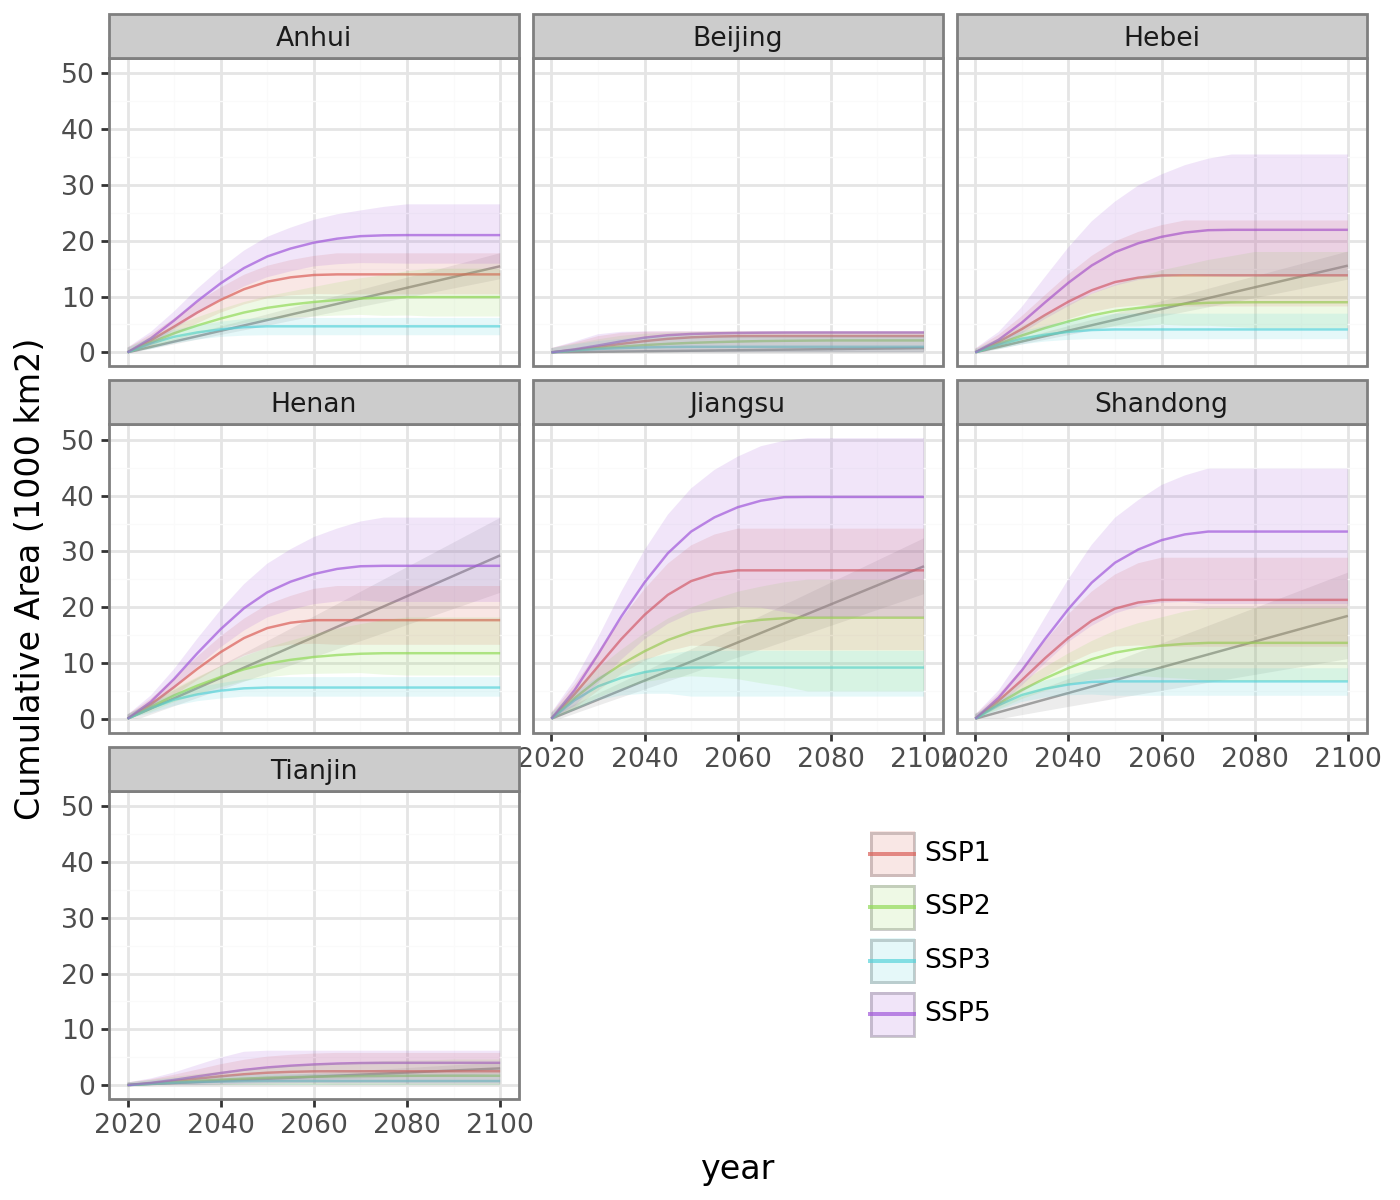

In [85]:
# plot the area change
plotnine.options.figure_size = (7,6)
plotnine.options.dip = 100

g = (ggplot()
  # cropland increase pred
  + geom_line(cropland_increase_since_2020,aes(x='year',y='mean'),color='grey',size=0.5,alpha=0.7)
  + geom_ribbon(cropland_increase_since_2020,aes(x='year',ymin='obs_ci_lower',ymax='obs_ci_upper'),fill='grey',size=0.5,alpha=0.15)

  # urban excroachment pred
  + geom_line(urban_encroachment_area_df,aes(x='year',y='encroach_area_1000km2_mean',color='Scenario'),alpha=0.7)
  + geom_ribbon(urban_encroachment_area_df,aes(x='year',ymin='encroach_area_1000km2_bot',ymax='encroach_area_1000km2_top',
                                fill='Scenario'),alpha=0.15)
  + facet_wrap('Province',ncol=3)
  + theme_bw(base_size=12)
  + theme(subplots_adjust={'wspace': 0.1})
  + ylab('Cumulative Area (1000 km2)')
  + theme(legend_title=element_blank(),legend_position=(0.67,0.07),legend_background=element_blank())
 )

g

In [20]:
# g.save('/content/result_2_3_encroach_increase_compare.svg')

c:\Users\Jinzhu\miniconda3\envs\gee\Lib\site-packages\plotnine\themes\themeable.py:2398: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


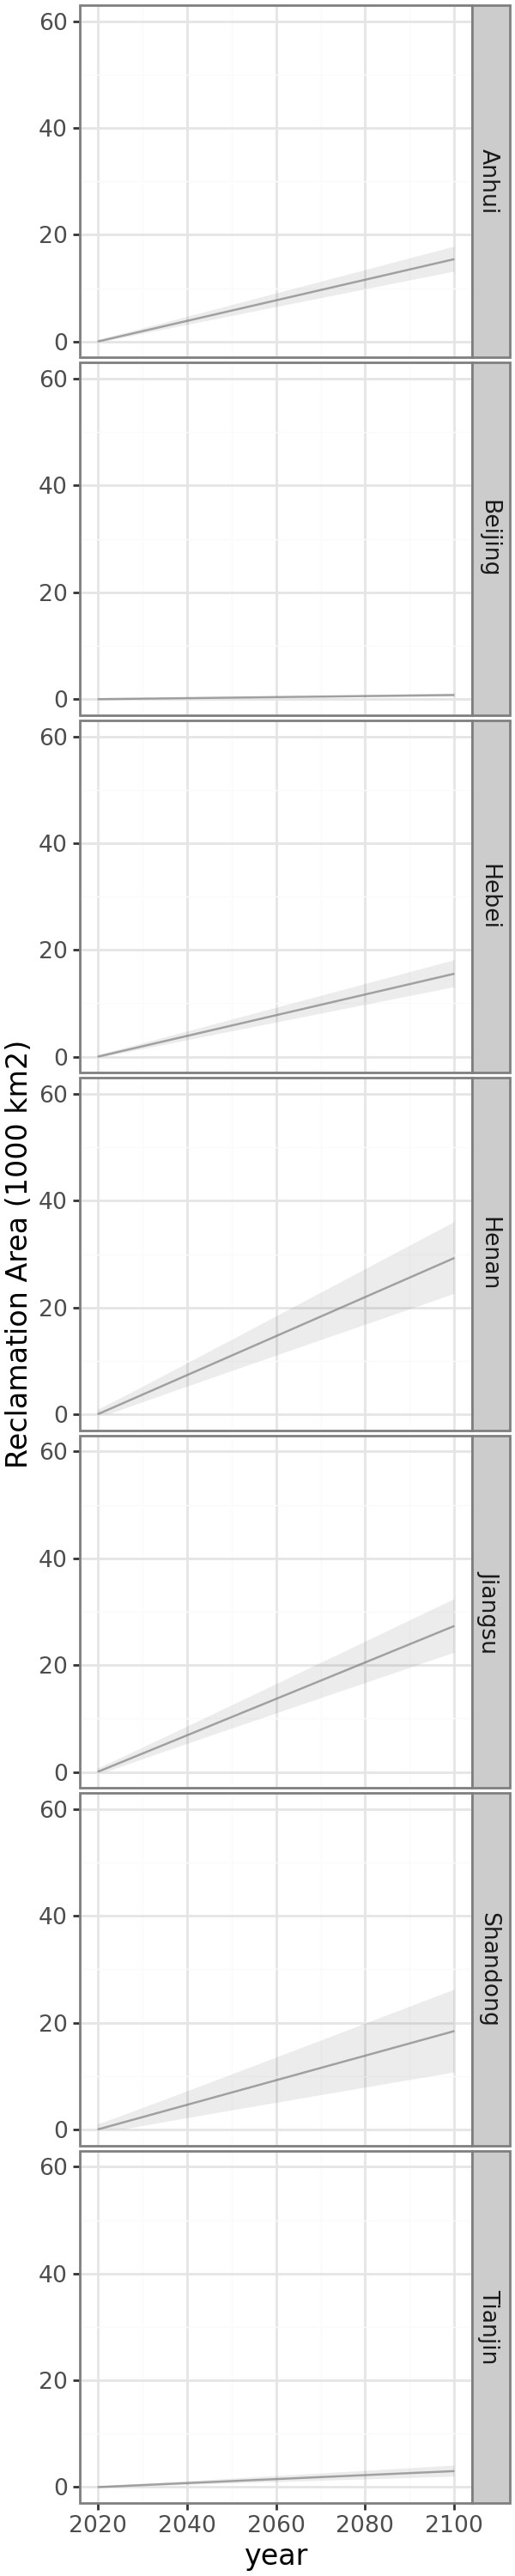

In [21]:
# plot the area change
plotnine.options.figure_size = (3,15)
plotnine.options.dip = 100

g = (ggplot()
  # cropland increase pred
  + geom_line(cropland_increase_since_2020,aes(x='year',y='mean'),color='grey',size=0.5,alpha=0.7)
  + geom_ribbon(cropland_increase_since_2020,aes(x='year',ymin='obs_ci_lower',ymax='obs_ci_upper'),fill='grey',size=0.5,alpha=0.15)
  + coord_cartesian(ylim=(0,60))
  # + facet_wrap('Province',ncol=1)
  + facet_grid('Province ~ .')
  + theme_bw(base_size=12)
  + theme(subplots_adjust={'wspace': 0.1})
  + ylab('Reclamation Area (1000 km2)')
  + theme(legend_title=element_blank(),legend_background=element_blank())
 )

g

In [22]:
# g.save('/content/result_2_5_1_cropland_gain.svg')

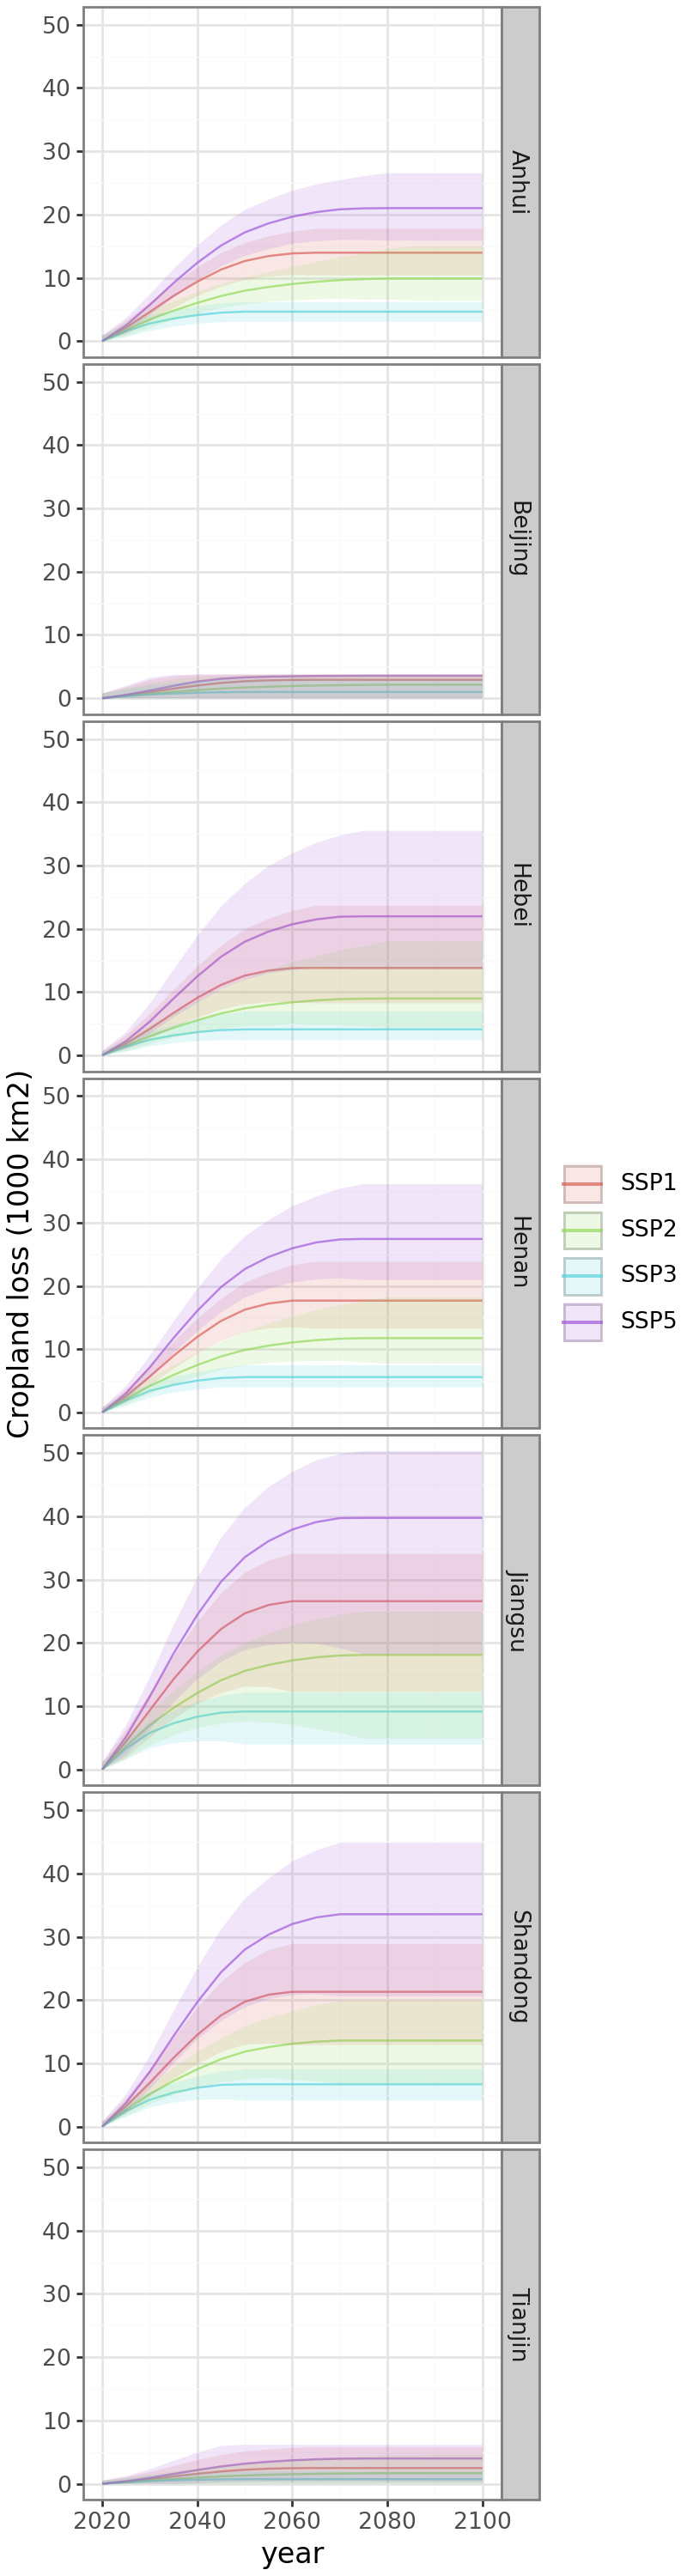

In [23]:
# plot the area change
plotnine.options.figure_size = (4,15)
plotnine.options.dip = 100

g = (ggplot() 
  # urban excroachment pred
  + geom_line(urban_encroachment_area_df,aes(x='year',y='encroach_area_1000km2_mean',color='Scenario'),alpha=0.7)
  + geom_ribbon(urban_encroachment_area_df,aes(x='year',ymin='encroach_area_1000km2_bot',ymax='encroach_area_1000km2_top',
                                fill='Scenario'),alpha=0.15)
  # + facet_wrap('Province',ncol=1)
  + facet_grid('Province ~ .')
  + theme_bw(base_size=12)
  # + theme(subplots_adjust={'wspace': 0.1})
  + ylab('Cropland loss (1000 km2)')
  + theme(legend_title=element_blank(),legend_background=element_blank())
 )

g

In [24]:
# g.save('/content/result_2_5_2_cropland_loss.svg')

In [25]:
# merge cropland_increase with cropland_decrease to compute net cropland change
net_cropland_change = urban_encroachment_area_df.merge(future_cropland_increase)
net_cropland_change = net_cropland_change \
  >> mutate(net_mean = (-X.encroach_area_1000km2_mean + X['mean']/100),
        net_top = (-X.encroach_area_1000km2_bot + X.obs_ci_upper/100),
        net_bot = (-X.encroach_area_1000km2_top + X.obs_ci_lower/100))
  

c:\Users\Jinzhu\miniconda3\envs\gee\Lib\site-packages\plotnine\themes\themeable.py:2398: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


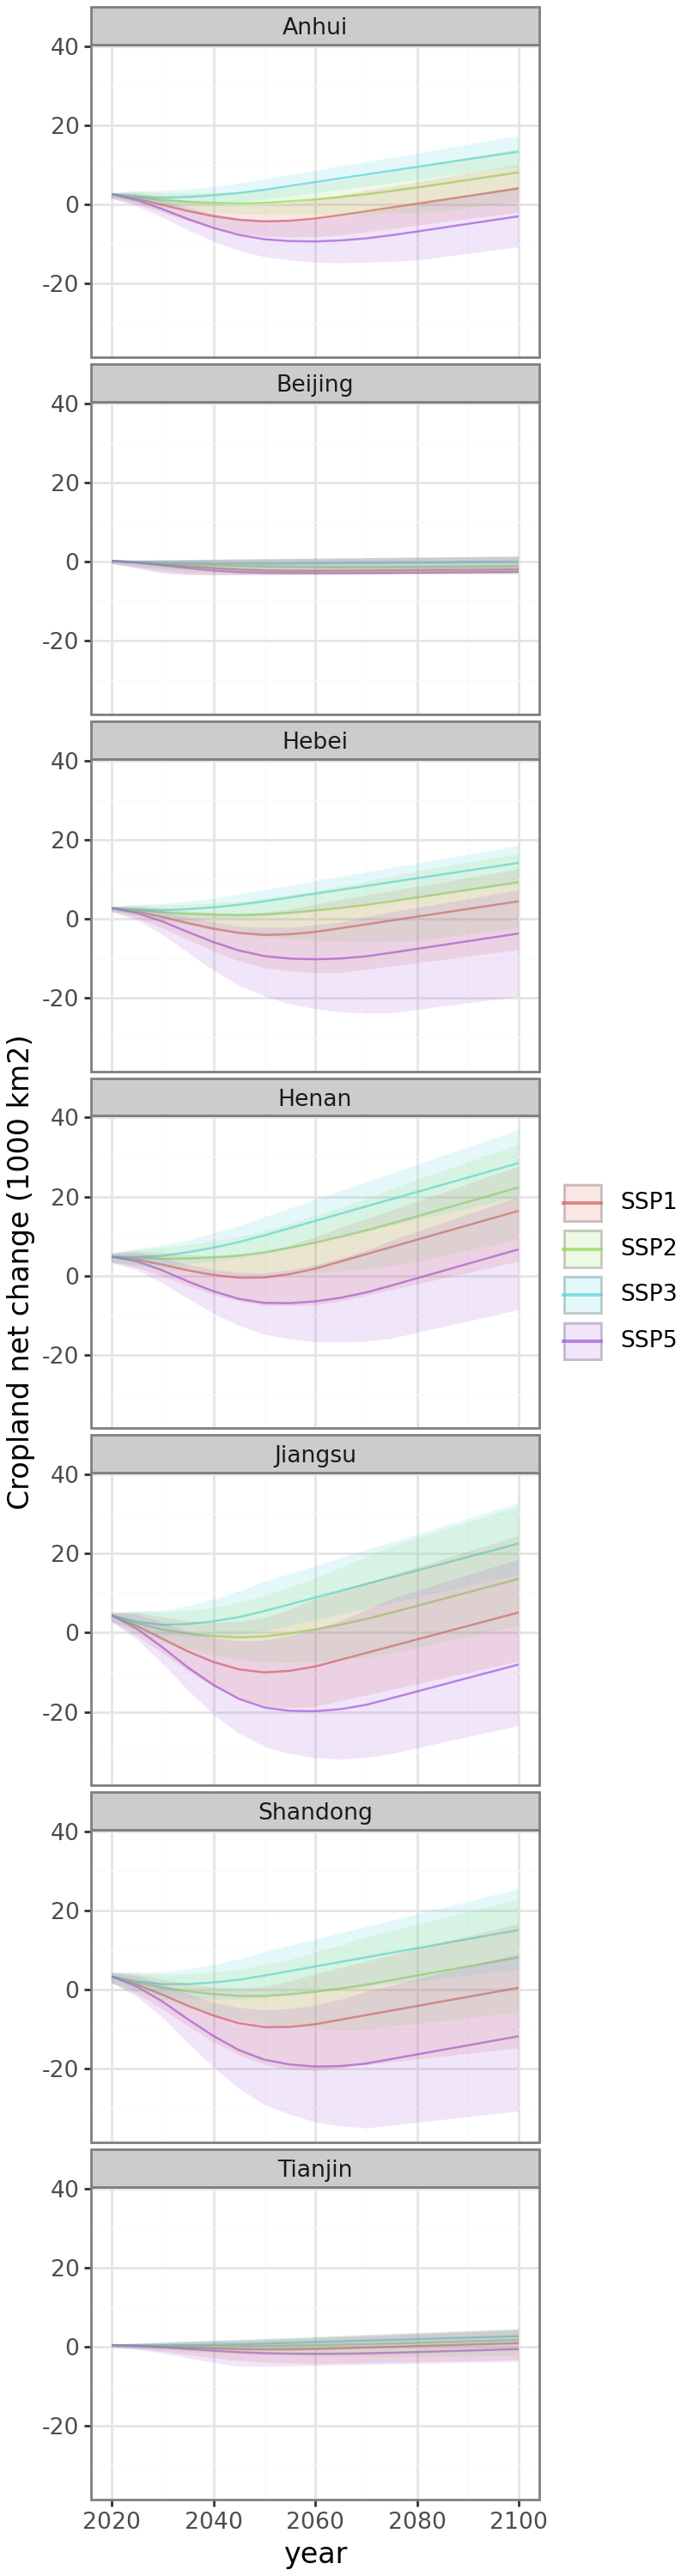

In [26]:
# plot the area change
plotnine.options.figure_size = (4,15)
plotnine.options.dip = 100

g = (ggplot() 
  # urban excroachment pred
  + geom_line(net_cropland_change,aes(x='year',y='net_mean',color='Scenario'),alpha=0.7)
  + geom_ribbon(net_cropland_change,aes(x='year',ymin='net_bot',ymax='net_top',fill='Scenario'),alpha=0.15)
  + facet_wrap('Province',ncol=1)
  + theme_bw(base_size=12)
  + theme(subplots_adjust={'wspace': 0.1})
  + ylab('Cropland net change (1000 km2)')
  + theme(legend_title=element_blank(),legend_background=element_blank())
 )

g

In [27]:
# g.save('/content/result_2_5_3_cropland_net_change.svg')

#### 2-4) Combine urban encrochment with cropland increase

In [93]:
# get the total cropland area
cropland_area_after_encroachment_sum = cropland_area_after_encroachment.groupby(['Scenario','year','Province']).sum(numeric_only=True).reset_index()


# get the yearbook_area_province_sum
yearbook_area_province_sum = yearbook_area.groupby(['Province','year'])[['area_yearbook_kha']].sum(numeric_only=True).reset_index()
yearbook_area_province_sum['yearbook_area_1000km2'] = yearbook_area_province_sum['area_yearbook_kha'] / 100

In [94]:
cropland_area_after_encroachment_sum

,Scenario,year,Province,area_after_encroachment_kha,area_after_encroachment_kha_bot,area_after_encroachment_kha_top
0,SSP1,2020,Anhui,6530.777119,6602.372051,6447.482719
1,SSP1,2020,Beijing,75.813787,90.859141,34.080891
2,SSP1,2020,Hebei,5690.430005,5695.067119,5622.139865
3,SSP1,2020,Henan,10064.222233,10120.094554,9993.781994
4,SSP1,2020,Jiangsu,5059.713186,5152.652578,4957.404636
...,...,...,...,...,...,...
583,SSP5,2100,Hebei,3628.219152,4398.296095,2551.678720
584,SSP5,2100,Henan,7384.716361,8004.883403,6573.644522
585,SSP5,2100,Jiangsu,1686.623626,3328.225764,1030.931714
586,SSP5,2100,Shandong,4803.711146,5939.162775,3911.811776


In [90]:
# link cropland_area_2020, urban_encroachment_area, and future_cropland_increase
final_cropland_area = cropland_area_after_encroachment_sum.merge(cropland_increase_since_2020)
final_cropland_area = final_cropland_area \
  >> mutate(final_cropland_area_1000km2 = (X.area_after_encroachment_kha/100  + X['mean']),
       final_cropland_area_1000km2_top = (X.area_after_encroachment_kha_top/100  + (X.obs_ci_upper - X['mean'])),  
       final_cropland_area_1000km2_bot = (X.area_after_encroachment_kha_bot/100  -  (X.obs_ci_upper - X['mean'])))
  
final_cropland_area = final_cropland_area >> select(['Scenario','Province','year','final_cropland_area_1000km2',
                            'final_cropland_area_1000km2_top','final_cropland_area_1000km2_bot'])
final_cropland_area = final_cropland_area.sort_values(['Province','Scenario','year'])

In [92]:
cropland_area_after_encroachment_sum

,Scenario,year,Province,area_after_encroachment_kha,area_after_encroachment_kha_bot,area_after_encroachment_kha_top
0,SSP1,2020,Anhui,6530.777119,6602.372051,6447.482719
1,SSP1,2020,Beijing,75.813787,90.859141,34.080891
2,SSP1,2020,Hebei,5690.430005,5695.067119,5622.139865
3,SSP1,2020,Henan,10064.222233,10120.094554,9993.781994
4,SSP1,2020,Jiangsu,5059.713186,5152.652578,4957.404636
...,...,...,...,...,...,...
583,SSP5,2100,Hebei,3628.219152,4398.296095,2551.678720
584,SSP5,2100,Henan,7384.716361,8004.883403,6573.644522
585,SSP5,2100,Jiangsu,1686.623626,3328.225764,1030.931714
586,SSP5,2100,Shandong,4803.711146,5939.162775,3911.811776


c:\Users\Jinzhu\miniconda3\envs\gee\Lib\site-packages\plotnine\themes\themeable.py:2398: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


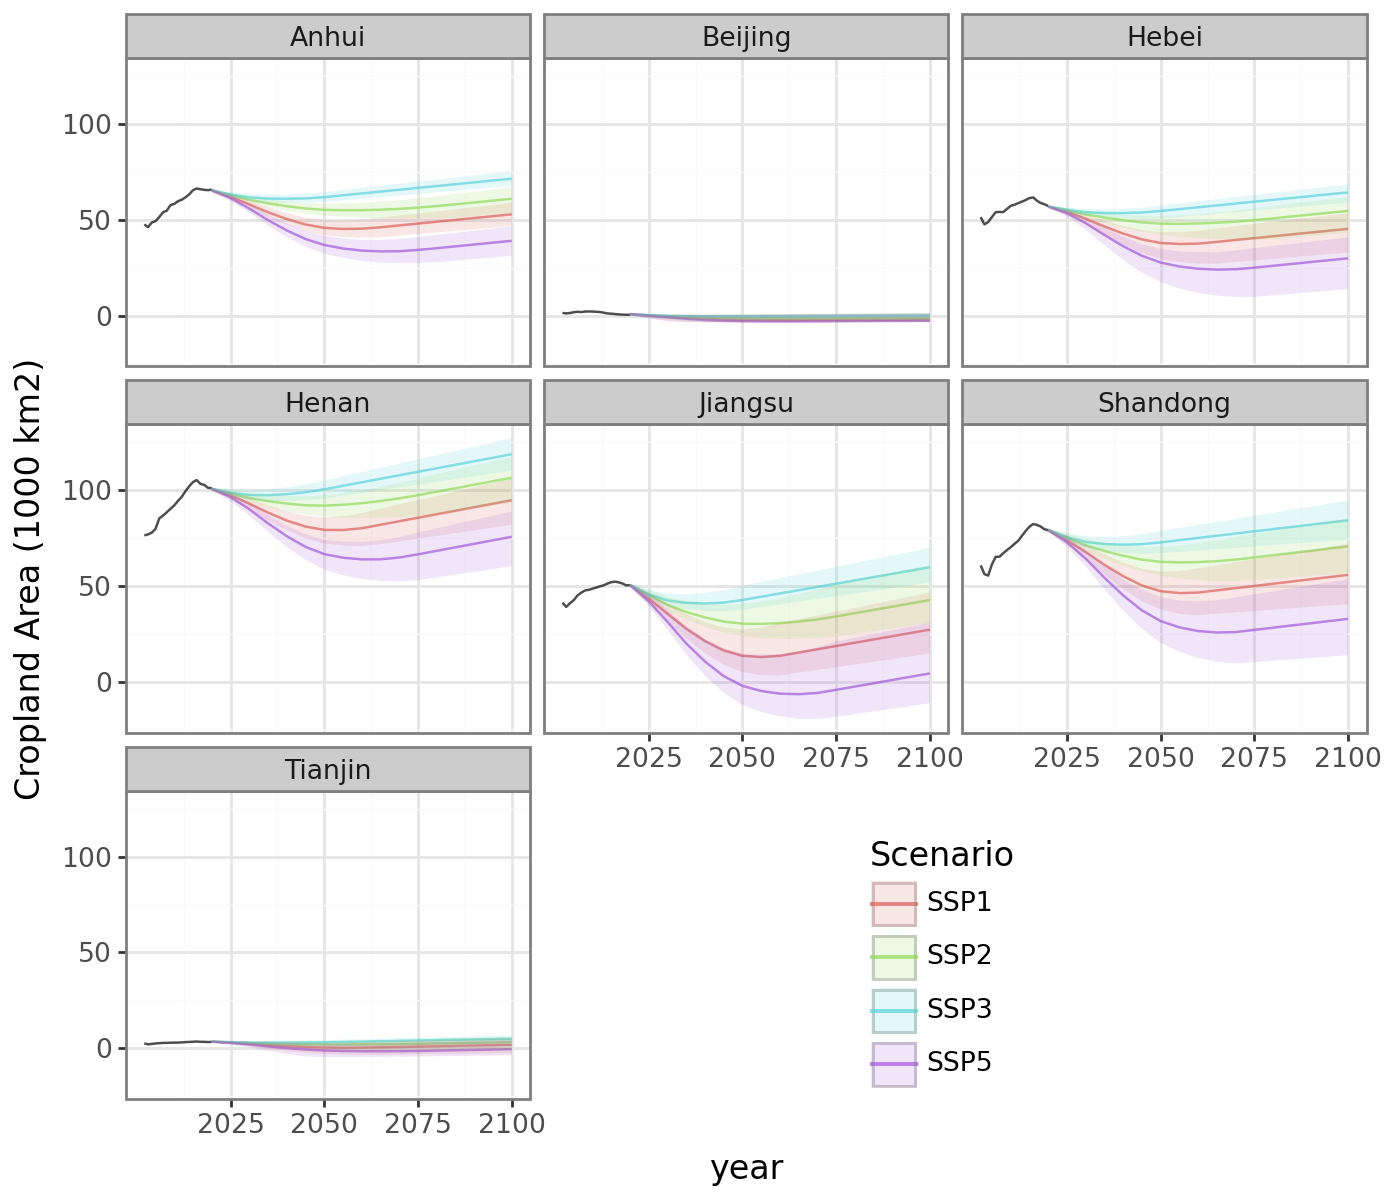

In [72]:
# plot the area change
plotnine.options.figure_size = (7,6)
plotnine.options.dip = 100

g = (ggplot()
  # historical cropland
  + geom_line(yearbook_area_province_sum,aes(x='year',y='yearbook_area_1000km2'),alpha=0.7)
  # urban excroachment pred
  + geom_line(final_cropland_area,aes(x='year',y='final_cropland_area_1000km2',color='Scenario'),alpha=0.7)
  + geom_ribbon(final_cropland_area,
        aes(x='year',ymin='final_cropland_area_1000km2_bot',ymax='final_cropland_area_1000km2_top',fill='Scenario'),alpha=0.15)
  + scale_x_continuous(breaks = range(2025,2101,25))
  + facet_wrap(['Province'],ncol=3)
  + theme_bw(base_size=12)
  + theme(subplots_adjust={'wspace': 0.1},legend_position=(0.68,0.01))
  + ylab('Cropland Area (1000 km2)')
 )

g

In [31]:
# g.save('/content/result_2_4_final_cropland_area.svg')

c:\Users\Jinzhu\miniconda3\envs\gee\Lib\site-packages\plotnine\themes\themeable.py:2398: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


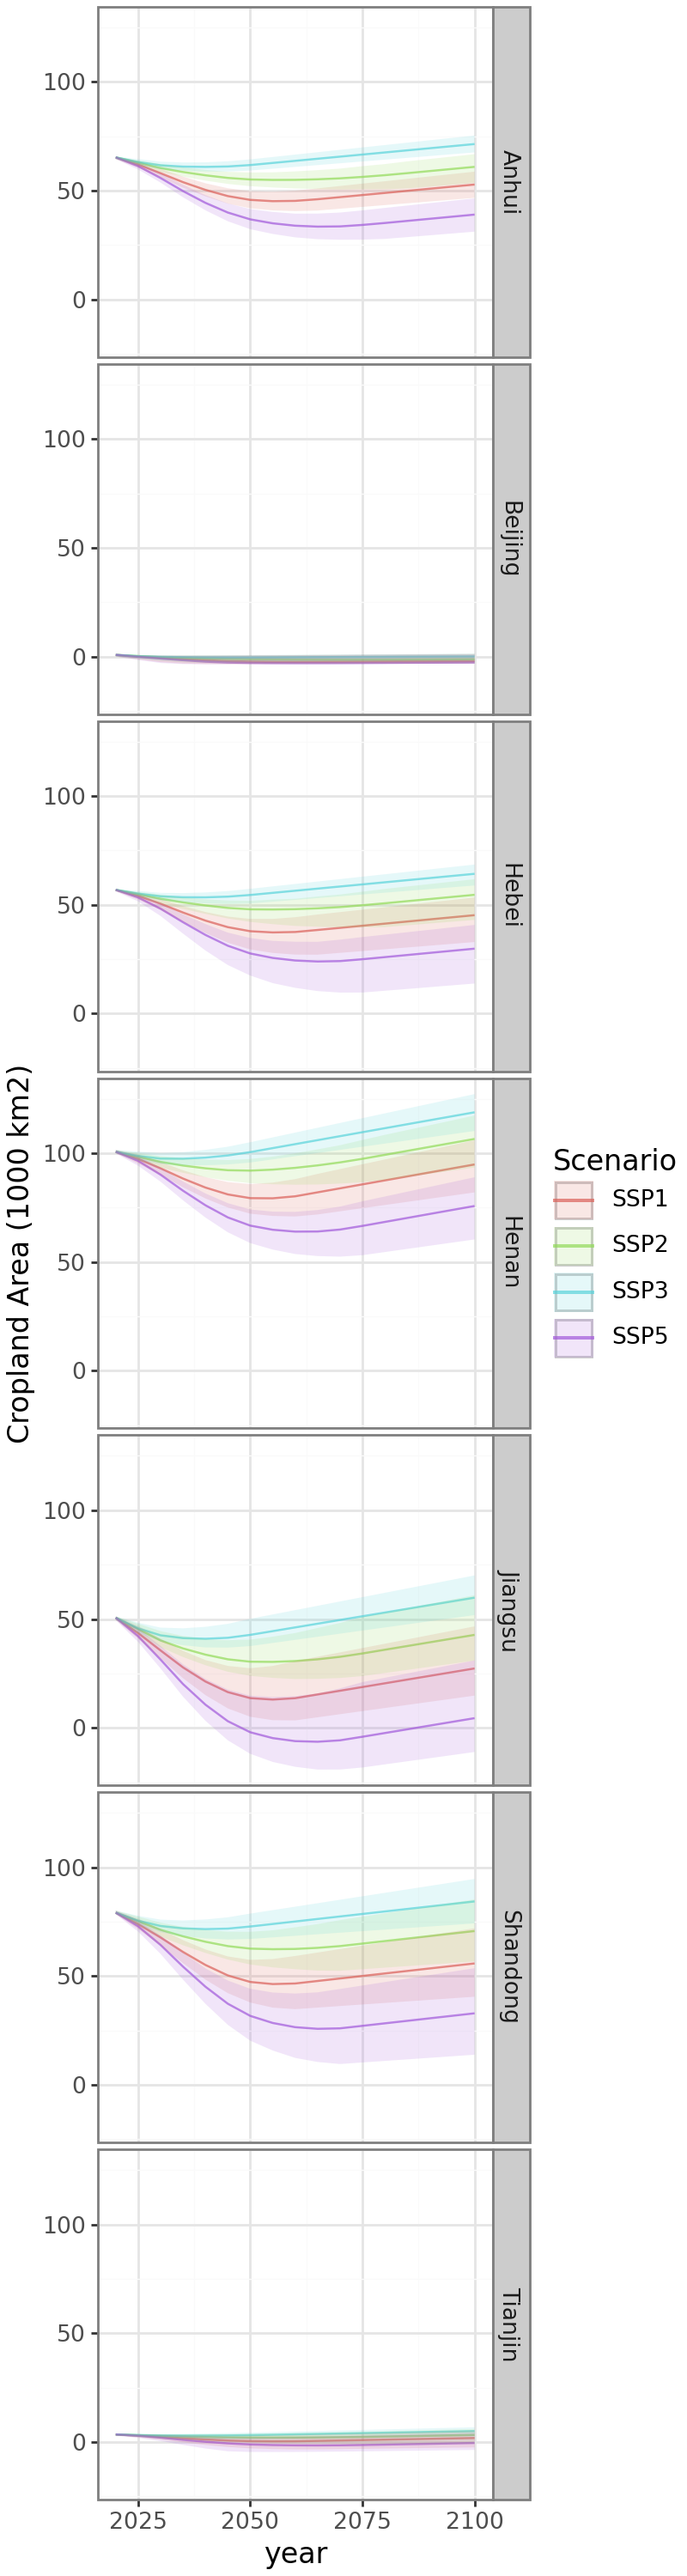

In [32]:
# plot the area change
plotnine.options.figure_size = (4,15)
plotnine.options.dip = 100

g = (ggplot()
  # # historical cropland
  # + geom_line(yearbook_area_province_sum,aes(x='year',y='area_yearbook_1000km2'),alpha=0.7)
  # urban excroachment pred
  + geom_line(final_cropland_area,aes(x='year',y='final_cropland_area_1000km2',color='Scenario'),alpha=0.7)
  + geom_ribbon(final_cropland_area,
        aes(x='year',ymin='final_cropland_area_1000km2_bot',ymax='final_cropland_area_1000km2_top',fill='Scenario'),alpha=0.15)
  + scale_x_continuous(breaks = range(2025,2101,25))
  # + facet_wrap(['Province'],ncol=1)
  + facet_grid('Province ~ .')
  + theme_bw(base_size=12)
  + theme(subplots_adjust={'wspace': 0.1})
  + ylab('Cropland Area (1000 km2)')
 )

g

In [33]:
# g.save('/content/result_2_5_4_cropland_final.svg')

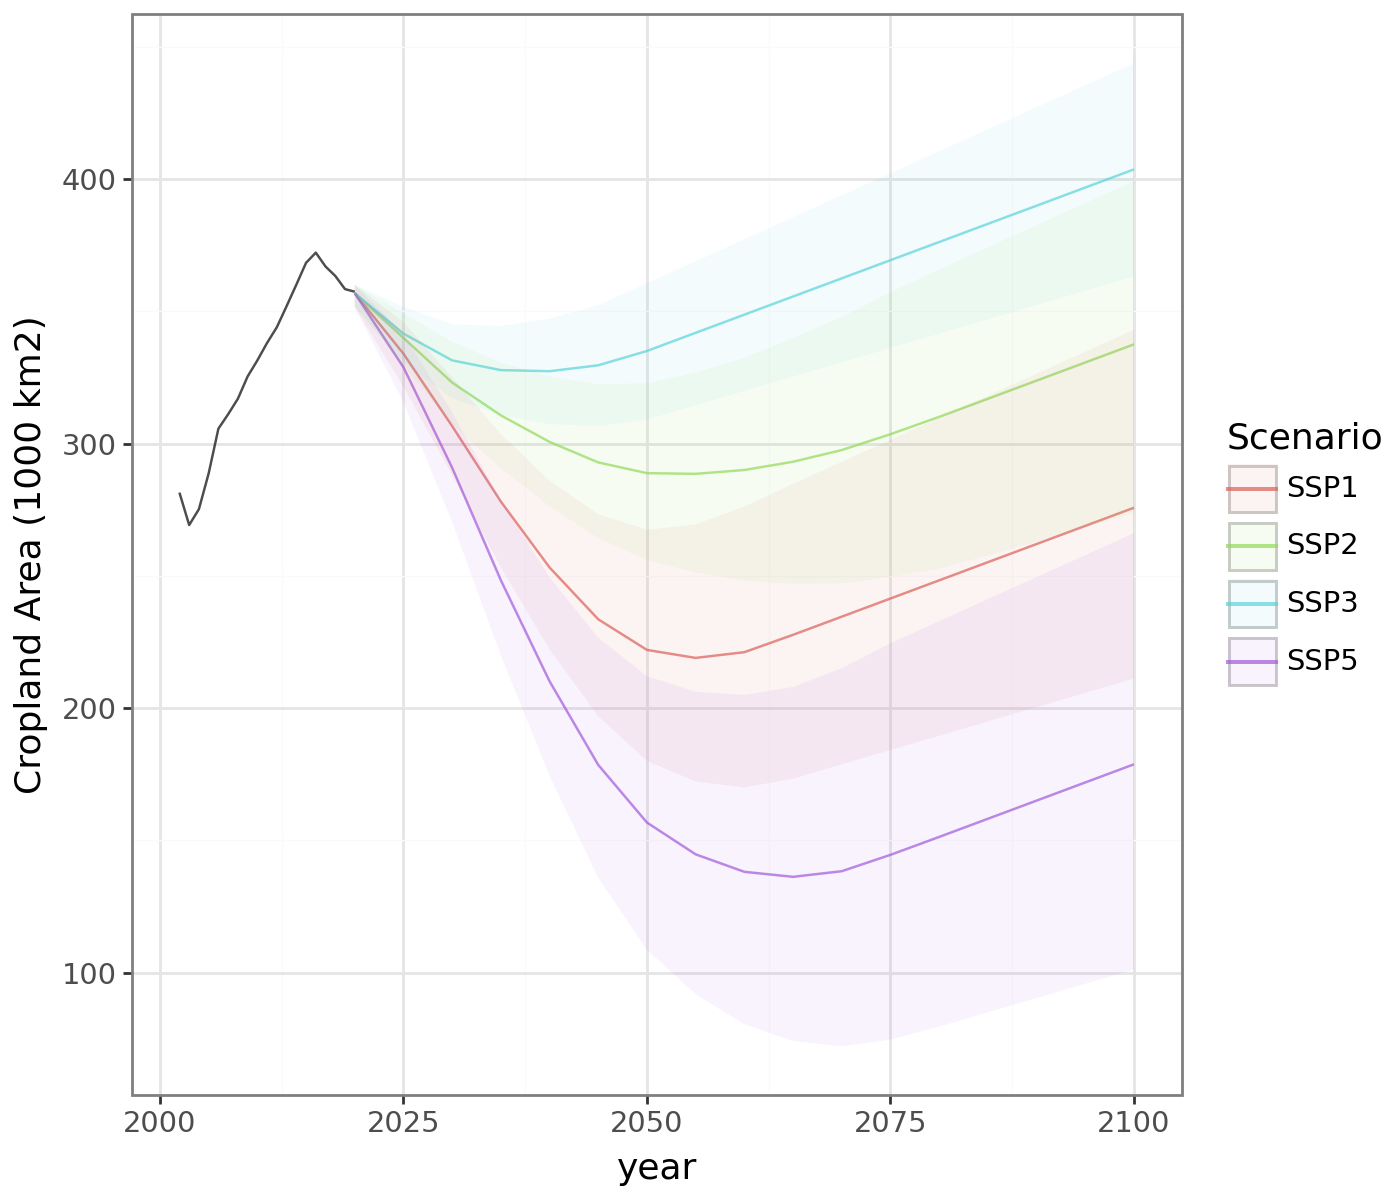

In [67]:
# compute the total change
final_cropland_area_pred_sum = final_cropland_area.groupby(['Scenario','year']).sum(numeric_only=True).reset_index()

yearbook_area_province_sum_total = yearbook_area_province_sum.groupby('year').sum(numeric_only=True).reset_index()

# plot the area change
plotnine.options.figure_size = (7,6)
plotnine.options.dip = 100

(ggplot()
# historical cropland
+ geom_line(yearbook_area_province_sum_total,aes(x='year',y='yearbook_area_1000km2'),alpha=0.7)
# urban excroachment pred
+ geom_line(final_cropland_area_pred_sum,
            aes(x='year',y='final_cropland_area_1000km2',color='Scenario'),alpha=0.7)
+ geom_ribbon(final_cropland_area_pred_sum,
       aes(x='year',ymin='final_cropland_area_1000km2_bot',ymax='final_cropland_area_1000km2_top',fill='Scenario'),alpha=0.07)
# + facet_wrap(['Province'],ncol=3)
# + scale_x_continuous(breaks=range(2000,2101,10))
+ theme_bw(base_size=13)
# yscale from 0 to 1000
# + coord_cartesian(ylim=(0,450))
+ ylab('Cropland Area (1000 km2)')
 )

#### 2-5) the stopping point of cropland_area increase

- The cropland increase will not stop because the sum of future_cropland and future_urban can't reach the total area of historical sum_urban_cropland

In [35]:
# 1) get the future urban area
future_pred_area = pd.read_csv('./result_csv/future_pred_area.csv') >> rename(Scenario='ssp')
future_pred_area.head()

,Province,area_1000_km2,area_1000_km2_bot,area_1000_km2_top,year,Scenario
0,Shandong,24.755892,25.800669,23.639050,2020,SSP1
1,Henan,19.519899,20.533549,18.462789,2020,SSP1
2,Beijing,3.270219,4.350006,2.212793,2020,SSP1
3,Tianjin,2.739711,3.634174,1.826362,2020,SSP1
4,Hebei,15.996800,17.124866,14.957512,2020,SSP1


In [36]:
# 2) the future cropland area
final_cropland_area.head()

,Scenario,Province,year,final_cropland_area_1000km2,final_cropland_area_1000km2_top,final_cropland_area_1000km2_bot
0,SSP1,Anhui,2020,65.307771,65.595036,64.468495
7,SSP1,Anhui,2025,62.015419,63.503565,60.552974
14,SSP1,Anhui,2030,58.009143,60.019909,56.042567
21,SSP1,Anhui,2035,53.900752,56.466389,51.366515
28,SSP1,Anhui,2040,50.352012,53.395979,47.380093


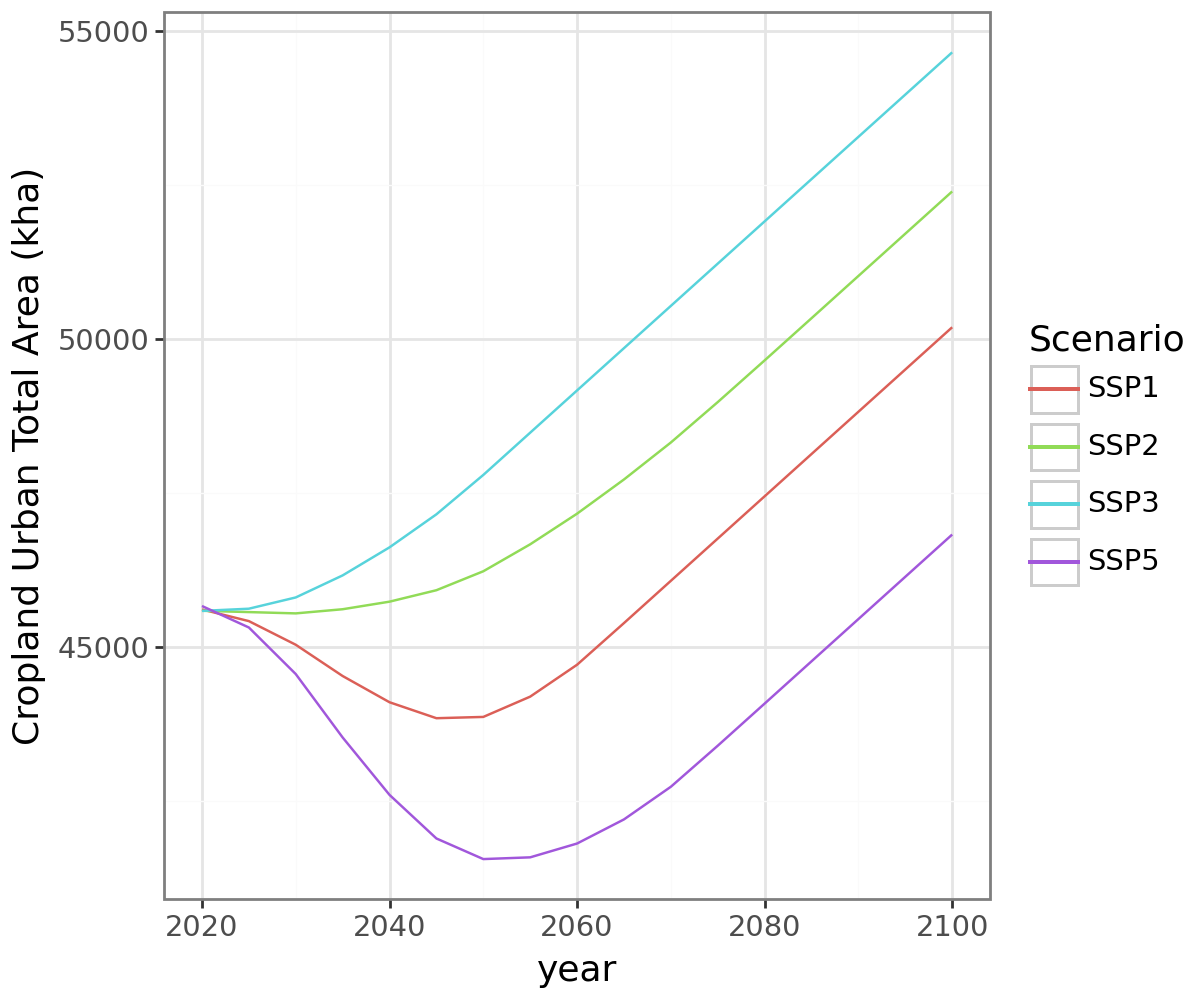

In [37]:
# 3) future cropland_&_urban area
future_crop_and_urban_area = final_cropland_area.merge(future_pred_area)
future_crop_and_urban_area.head()

# 4) urban_cropland_sum
future_crop_and_urban_area = future_crop_and_urban_area \
                >> mutate(urban_cropland_sum_kha = (X.final_cropland_area_1000km2)*100 + (X.area_1000_km2)*100)

future_crop_and_urban_area_sum = future_crop_and_urban_area.groupby(['Scenario','year']).sum().reset_index()

# 5) plot the urban_cropland_sum
plotnine.options.figure_size = (6,5)
plotnine.options.dip = 100

# plot the trend
(ggplot()
 # total area of this study
 + geom_line(future_crop_and_urban_area_sum,aes(x='year',y='urban_cropland_sum_kha',color='Scenario'))
 + theme_bw(base_size=13)
 + ylab('Cropland Urban Total Area (kha)')
)

In [38]:
# get the lucc img df
LUCC_NCP_df = pd.DataFrame({k:[v] for k,v in LUCC_NCP.items()}).T.reset_index()
LUCC_NCP_df.columns = ['year','lucc_img']

NCP_urban_df = pd.DataFrame({yr:[NCP_urban_maps.gte(val)] for yr,val in year_val_code}).T.reset_index()
NCP_urban_df.columns = ['year','urban_img']

# combine lucc_img with NCP_urban_img
lucc_with_urban = LUCC_NCP_df.merge(NCP_urban_df)

In [ ]:
# compute the total area of urban(8) and cropland(1)
def compute_total_area(in_df):
  print(' ',end='',flush=True)

  df_list = []
  for idx,row in tqdm(in_df.iterrows(),total=len(in_df)):
    in_img = row['lucc_img'].eq(1).Or(row['lucc_img'].eq(8))
    area_img = ee.Image.pixelArea().updateMask(in_img)

    stats = area_img.reduceRegions(collection=NCP_shp,scale=30,reducer='sum').getInfo()

    stats_df = pd.DataFrame({i['properties']['EN_Name']:[i['properties']['sum']] for i in stats['features']}).T.reset_index()
    stats_df.columns = ['Province','area_m2']

    stats_df['area_kha'] = stats_df['area_m2']/10000/1000
    stats_df['year'] = row['year']

    df_list.append(stats_df)

  return pd.concat(df_list).reset_index(drop=True)

# get the total arae of cropland and urban for lucc
lucc_cropland_urban_province_sum = parallelize_dataframe(LUCC_NCP_df,compute_total_area,15).reset_index(drop=True)
lucc_cropland_urban_sum = lucc_cropland_urban_province_sum.groupby('year').sum().reset_index()

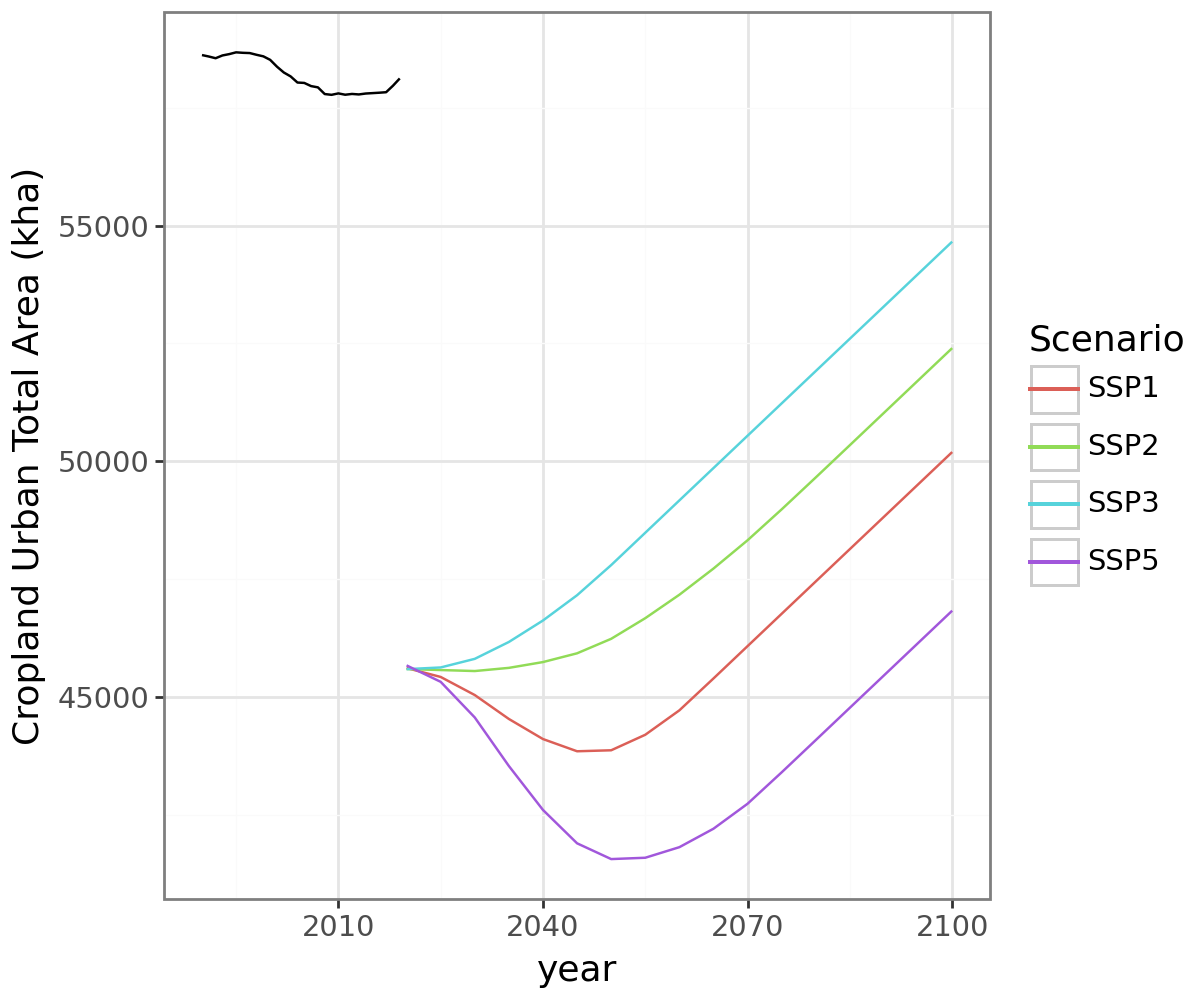

In [40]:
# 6) plot the urban_cropland_sum
plotnine.options.figure_size = (6,5)
plotnine.options.dip = 100

# plot the trend
g = (ggplot()
 # total area of this study
 + geom_line(future_crop_and_urban_area_sum,aes(x='year',y='urban_cropland_sum_kha',color='Scenario'))
 + geom_line(lucc_cropland_urban_sum,aes(x='year',y='area_kha'))
 + theme_bw(base_size=13)
 + ylab('Cropland Urban Total Area (kha)')
)

g

In [41]:
# g.save('/content/sup_9_sum_of_urban_cropland.svg')

### 3) convert cropland_increase to imgs

#### 3-1) determine the area ratio for each crop/water in every province
- The cropland increase record is a single value for each province
- So, so we need to distribute this value to each pixel for the crop/water layer

In [42]:
# compute the total cropland area (crop/water) for each province
total_cropland_area_img = ee.ImageCollection([ee.Image(i).unmask() for i in GAEZ_cropland_2020_corrected['GAEZ_2020_cropland_corrcted']]).sum()
total_cropland_area_stats = total_cropland_area_img.reduceRegions(reducer='sum',collection=NCP_shp,scale=GAEZ_pix_scale).getInfo()

total_cropland_area_df = pd.DataFrame({i['properties']['EN_Name']:[i['properties']['sum']] \
                                      for i in total_cropland_area_stats['features']}).T.reset_index()

total_cropland_area_df.columns = ['Province','total_cropland_area_kha']                   

In [43]:
# compute the cropland area for each crop/water at every province
area_dfs = []
for idx,row in tqdm(GAEZ_cropland_2020_corrected.iterrows(),total=len(GAEZ_cropland_2020_corrected)):
  crop = row['crop']
  water = row['water']
  img = ee.Image(row['GAEZ_2020_cropland_corrcted']).unmask()

  area_stats = img.reduceRegions(reducer='sum',collection=NCP_shp,scale=GAEZ_pix_scale).getInfo()
  area_df = pd.DataFrame({i['properties']['EN_Name']:[i['properties']['sum']] \
                  for i in area_stats['features']}).T.reset_index()

  area_df.columns = ['Province','cropland_area_kha']

  area_df['crop'] = crop
  area_df['water'] = water

  area_dfs.append(area_df)

# concat all dfs to one df
area_df_crop_water = pd.concat(area_dfs).reset_index(drop=True)

  0%|          | 0/6 [00:00<?, ?it/s]

In [44]:
# merge all_area with each_crop_area to compute the cropland_area ratio
cropland_area_ratio = area_df_crop_water.merge(total_cropland_area_df)
cropland_area_ratio['total_area_ratio'] = cropland_area_ratio['cropland_area_kha']/cropland_area_ratio['total_cropland_area_kha']
cropland_area_ratio.head(6)

,Province,cropland_area_kha,crop,water,total_cropland_area_kha,total_area_ratio
0,Shandong,3163.895205,Maize,Irrigated,7923.624872,0.399299
1,Henan,2780.526825,Maize,Irrigated,10100.598974,0.275283
2,Beijing,48.195562,Maize,Irrigated,75.813787,0.635710
3,Tianjin,151.013897,Maize,Irrigated,346.767897,0.435490
4,Hebei,2787.847060,Maize,Irrigated,5701.720208,0.488948
5,Anhui,601.847589,Maize,Irrigated,6542.946742,0.091984


#### 3-2) seperate the reclamation_area to each crop/water at every province

In [56]:
cropland_increase_since_2020

,Province,year,mean,obs_ci_lower,obs_ci_upper,area_kha,area_kha_bot,area_kha_top
0,Anhui,2020,0.000000,0.000000,0.287265,0.000000,0.000000,28.726508
1,Anhui,2021,0.193023,0.000000,0.498347,19.302287,0.000000,49.834700
2,Anhui,2022,0.386046,0.061467,0.710624,38.604574,6.146708,71.062440
3,Anhui,2023,0.579069,0.234240,0.923897,57.906861,23.424015,92.389707
4,Anhui,2024,0.772091,0.406183,1.138000,77.209148,40.618315,113.799981
...,...,...,...,...,...,...,...,...
562,Tianjin,2096,2.845355,1.850119,3.840590,284.535488,185.011926,384.059050
563,Tianjin,2097,2.882794,1.875682,3.889906,288.279376,187.568160,388.990592
564,Tianjin,2098,2.920233,1.901243,3.939223,292.023264,190.124262,393.922266
565,Tianjin,2099,2.957672,1.926802,3.988541,295.767152,192.680235,398.854069


In [57]:
# compute the reclamation_area for each crop/water/province/year
reclamation_with_total_area_ratio = cropland_area_ratio.merge(cropland_increase_since_2020)

# compute the cropland_increase for each province                  
reclamation_with_total_area_ratio['reclamation_increase_kha'] = reclamation_with_total_area_ratio['area_kha']\
                                    * reclamation_with_total_area_ratio['total_area_ratio']
reclamation_with_total_area_ratio['reclamation_increase_kha_bot'] = reclamation_with_total_area_ratio['area_kha_bot']\
                                    * reclamation_with_total_area_ratio['total_area_ratio']
reclamation_with_total_area_ratio['reclamation_increase_kha_top'] = reclamation_with_total_area_ratio['area_kha_top']\
                                    * reclamation_with_total_area_ratio['total_area_ratio']

# select only necessary cols
reclamation_with_total_area_ratio = reclamation_with_total_area_ratio >> \
                    select(['Province','year','crop','water','reclamation_increase_kha',
                        'reclamation_increase_kha_bot','reclamation_increase_kha_top'])
                    
reclamation_with_total_area_ratio

,Province,year,crop,water,reclamation_increase_kha,reclamation_increase_kha_bot,reclamation_increase_kha_top
0,Shandong,2020,Maize,Irrigated,0.000000,0.000000,38.073212
1,Shandong,2021,Maize,Irrigated,9.204051,0.000000,49.670753
2,Shandong,2022,Maize,Irrigated,18.408102,0.000000,61.426739
3,Shandong,2023,Maize,Irrigated,27.612153,0.000000,73.314635
4,Shandong,2024,Maize,Irrigated,36.816204,0.000000,85.312546
...,...,...,...,...,...,...,...
3397,Jiangsu,2096,Wheat,Rainfed,103.075645,84.083813,122.067477
3398,Jiangsu,2097,Wheat,Rainfed,104.431904,85.213434,123.650373
3399,Jiangsu,2098,Wheat,Rainfed,105.788162,86.343031,125.233294
3400,Jiangsu,2099,Wheat,Rainfed,107.144421,87.472602,126.816239


In [58]:
# compute the pix_count for each crop/water, based on the cropland area of 2020
pix_count = []
for idx,row in tqdm(GAEZ_cropland_2020_corrected.iterrows(),total=len(GAEZ_cropland_2020_corrected)):
  crop = row['crop']
  water = row['water']
  crop_area_img = ee.Image(row['GAEZ_2020_cropland_corrcted'])

  stats = ee.Image(1).updateMask(crop_area_img.gt(0))\
        .reduceRegions(reducer='sum',collection=NCP_shp,scale=GAEZ_pix_scale).getInfo()

  pix_count_df = pd.DataFrame({i['properties']['EN_Name']:[i['properties']['sum']] 
                        for i in stats['features']}).T.reset_index()
                        
  pix_count_df.columns = ['Province','count']

  pix_count_df['crop'] = crop
  pix_count_df['water'] = water

  pix_count.append(pix_count_df)

# concat all dfs to one
pix_count_all = pd.concat(pix_count).reset_index(drop=True)

  0%|          | 0/6 [00:00<?, ?it/s]

In [60]:
# link the increase_area with pix_count
reclamation_each_pix = reclamation_with_total_area_ratio.merge(pix_count_all)
reclamation_each_pix['pix_increase_kha'] = reclamation_each_pix['reclamation_increase_kha']/reclamation_each_pix['count']
reclamation_each_pix['pix_increase_kha_bot'] = reclamation_each_pix['reclamation_increase_kha_bot']/reclamation_each_pix['count']
reclamation_each_pix['pix_increase_kha_top'] = reclamation_each_pix['reclamation_increase_kha_top']/reclamation_each_pix['count']

# convert Nan to 0
reclamation_each_pix = reclamation_each_pix.replace({np.nan:0})

# convert pix_increase value to imgs
reclamation_each_pix = reclamation_each_pix.merge(GAEZ_cropland_2020_corrected)
reclamation_each_pix['region_shp'] = NCP_shp

reclamation_each_pix['pix_increase_kha_img'] = reclamation_each_pix.apply(lambda row:ee.Image(row['GAEZ_2020_cropland_corrcted'])
                                .clip(row['region_shp'].filter(ee.Filter.eq('EN_Name',row['Province'])))
                                .multiply(0).add(row['pix_increase_kha']),1)
reclamation_each_pix['pix_increase_kha_img_bot'] = reclamation_each_pix.apply(lambda row:ee.Image(row['GAEZ_2020_cropland_corrcted'])
                                .clip(row['region_shp'].filter(ee.Filter.eq('EN_Name',row['Province'])))
                                .multiply(0).add(row['pix_increase_kha_bot']),1)
reclamation_each_pix['pix_increase_kha_img_top'] = reclamation_each_pix.apply(lambda row:ee.Image(row['GAEZ_2020_cropland_corrcted'])
                                .clip(row['region_shp'].filter(ee.Filter.eq('EN_Name',row['Province'])))
                                .multiply(0).add(row['pix_increase_kha_top']),1)

# select only necessary cols
reclamation_each_pix = reclamation_each_pix >> drop(['count','region_shp','reclamation_increase_kha',
                            'reclamation_increase_kha_bot','reclamation_increase_kha_top',
                            'pix_increase_kha','pix_increase_kha_bot','pix_increase_kha_top',	
                            'theme','variable','time','GEE_path'])

In [62]:
# mosaic the crop/water/year of the same year into a single img
reclamation_each_pix_mosaic = reclamation_each_pix.groupby(['crop','water','year'])\
                .apply(lambda df: [ee.ImageCollection(df['pix_increase_kha_img'].tolist()).mosaic(),
                           ee.ImageCollection(df['pix_increase_kha_img_bot'].tolist()).mosaic(),
                           ee.ImageCollection(df['pix_increase_kha_img_top'].tolist()).mosaic()])\
                .reset_index()

reclamation_each_pix_mosaic['pix_increase_kha_img'] = reclamation_each_pix_mosaic[0].apply(lambda x:x[0])
reclamation_each_pix_mosaic['pix_increase_kha_img_bot'] = reclamation_each_pix_mosaic[0].apply(lambda x:x[1])
reclamation_each_pix_mosaic['pix_increase_kha_img_top'] = reclamation_each_pix_mosaic[0].apply(lambda x:x[2])

reclamation_each_pix_mosaic = reclamation_each_pix_mosaic.drop(columns=[0])

# save to disk
reclamation_each_pix_mosaic.to_pickle('./result_csv/reclamation_each_pix_mosaic.pkl')

C:\Users\Jinzhu\AppData\Local\Temp\ipykernel_10588\1856366802.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


#### 3-3) validata the reclamation_img stats is the same as the future_cropland_increase

In [63]:
# remove historical imgs
reclamation_each_pix_mosaic_sum = reclamation_each_pix_mosaic.copy()

# get the sum of all reclamation imgs
reclamation_each_pix_mosaic_sum = reclamation_each_pix_mosaic_sum.groupby(['year'])\
            .apply(lambda df:[ee.ImageCollection([img for img in df['pix_increase_kha_img'].tolist()]).sum(),
                    ee.ImageCollection([img for img in df['pix_increase_kha_img_top'].tolist()]).sum(),
                    ee.ImageCollection([img for img in df['pix_increase_kha_img_bot'].tolist()]).sum()])\
            .reset_index()

# get the mean/top/bot imgs
reclamation_each_pix_mosaic_sum = reclamation_each_pix_mosaic_sum.rename({0:'imgs'}, axis=1)
reclamation_each_pix_mosaic_sum['reclamation_sum_img'] = reclamation_each_pix_mosaic_sum['imgs'].apply(lambda row:row[0])
reclamation_each_pix_mosaic_sum['reclamation_sum_img_top'] = reclamation_each_pix_mosaic_sum['imgs'].apply(lambda row:row[1])
reclamation_each_pix_mosaic_sum['reclamation_sum_img_bot'] = reclamation_each_pix_mosaic_sum['imgs'].apply(lambda row:row[2])

reclamation_each_pix_mosaic_sum = reclamation_each_pix_mosaic_sum >> drop('imgs')

C:\Users\Jinzhu\AppData\Local\Temp\ipykernel_10588\1235838847.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [64]:
# function to compute sum
def get_sum(in_df):
  print(' ',end='',flush=True)

  out_dfs=[]

  for idx,row in tqdm(in_df.iterrows(),total=len(in_df)):

    # get properties
    year = row['year']
    in_img = ee.Image([row['reclamation_sum_img'],row['reclamation_sum_img_top'],row['reclamation_sum_img_bot']])

    # compute the area of the input img
    stats = in_img.reduceRegions(collection=NCP_shp,
                    scale=GAEZ_pix_scale,
                    reducer=ee.Reducer.sum().repeat(3)).getInfo()

    # contructe the stats_df
    stats_data = pd.DataFrame({i['properties']['EN_Name']:i['properties']['sum'] 
                    for i in stats['features']}).T.reset_index()

    stats_data.columns = ['Province','area_kha','area_kha_top','area_kha_bot']
    stats_data['year'] = year

    out_dfs.append(stats_data)

  return pd.concat(out_dfs)


In [ ]:
# get the reclamation area from the reclamation_imgs
cropland_increase_df = parallelize_dataframe(reclamation_each_pix_mosaic_sum,get_sum,20)

# save to disk
cropland_increase_df.to_csv('./result_csv/cropland_increase_df.csv',index=False)

# read data
cropland_increase_df = pd.read_csv('./result_csv/cropland_increase_df.csv')

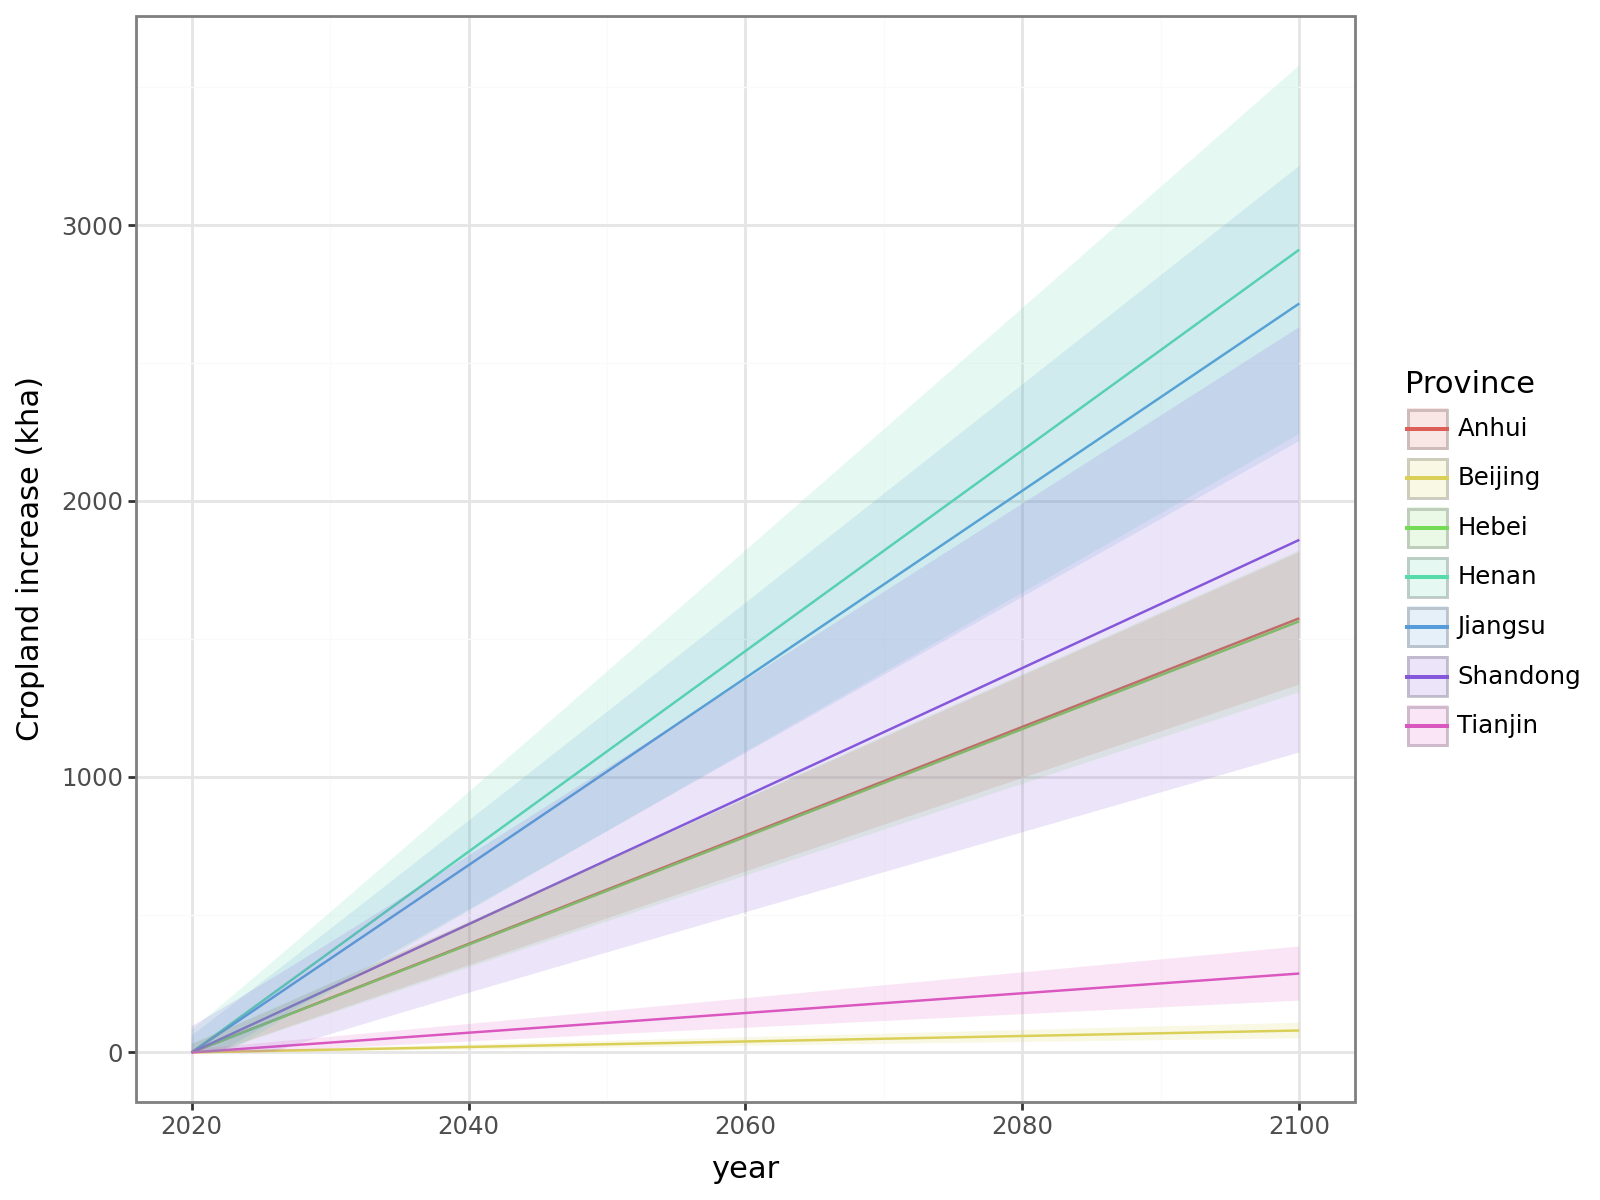

In [66]:
# plot the area change
plotnine.options.figure_size = (8,6)
plotnine.options.dip = 100

(ggplot()
 # pred cropland increase
 + geom_line(cropland_increase_df,aes(x='year',y='area_kha',color='Province'))
 + geom_ribbon(cropland_increase_df,aes(x='year',ymin='area_kha_bot',ymax='area_kha_top',fill='Province'),alpha=0.15)
 + theme_bw()
 + ylab('Cropland increase (kha)')    
)